In [27]:
import abc
import os
import inspect
import copy
from typing import Union, List, Optional, Tuple
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from scipy.signal import savgol_filter
import torch
from torch import Tensor
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data.dataset import TensorDataset
from torchvision.datasets import VisionDataset, CIFAR10, MNIST, FashionMNIST
from torch.utils.data import Dataset, DataLoader
import torch_pruning as tp

In [2]:
class ClassificationNet(torch.nn.Module, abc.ABC):
    def __init__(self, input_shape, output_shape, softmax) -> None:
        super().__init__()
        w, h, c = input_shape
        assert w == h
        self.c = c
        self.w = w

        self.feature_extractor = nn.Sequential(nn.Linear(w*h*c, 1)) # dumb
        classifier = [nn.Linear(1, output_shape)] # dumb
        if softmax:
            classifier.append(nn.Softmax(dim=-1))
        self.classifier = nn.Sequential(*classifier)
        self.softmax = softmax

    def forward(self, x: torch.Tensor):
        x = self.feature_extractor(x)
        return self.classifier(x)

    def forward_if(self, x: torch.Tensor, return_features: bool = False):
        f = self.feature_extractor(x)
        y = self.classifier(f)
        if return_features:
            return y, f
        return y

def get_pooling(pooling: str):
    if pooling == 'max':
        return torch.nn.MaxPool2d((2, 2))
    elif pooling == 'average':
        return torch.nn.AvgPool2d((2, 2))
    
class LeNet(ClassificationNet):
    def __init__(self, input_shape, output_shape, softmax, pooling):
        super(LeNet, self).__init__(input_shape, output_shape, softmax)

        def mini_conv_block(n_in, n_out, k_size, pad):
            return nn.Sequential(
                nn.Conv2d(n_in, n_out, k_size, padding=pad),
                nn.ReLU(),
                get_pooling(pooling)
            )

        self.feature_extractor = nn.Sequential(mini_conv_block(1, 6, 5, pad=2), 
                                               mini_conv_block(6, 16, 5, pad=0), 
                                               nn.Flatten(start_dim=1), 
                                               nn.Linear(16*5*5, 120), 
                                               nn.Linear(120, 84))
        classifier = [nn.Linear(84, output_shape)]
        if softmax:
            classifier.append(nn.Softmax(dim=-1))
        self.classifier = nn.Sequential(*classifier)

class SkipSequential(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        for layer in self.layers:
            x = layer(x)
        return x + residual
    
def r9_conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ClassificationNet):
    def __init__(self, input_shape, output_shape, softmax):
        super(ResNet9, self).__init__(input_shape, output_shape, softmax)
        
        self.feature_extractor = nn.Sequential(
            r9_conv_block(self.c, 64), # conv1
            r9_conv_block(64, 128, pool=True), # conv2
            SkipSequential(r9_conv_block(128, 128), r9_conv_block(128, 128)), # res 1
            r9_conv_block(128, 256, pool=True), # conv3
            r9_conv_block(256, 512, pool=True), # conv4
            SkipSequential(r9_conv_block(512, 512), r9_conv_block(512, 512)) # res 2
        )
        
        classifier = [
            nn.AdaptiveMaxPool2d((1,1)), 
            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(512, output_shape)
        ]
    
        if softmax:
            classifier.append(nn.Softmax(dim=-1))

        self.classifier = nn.Sequential(*classifier)

In [3]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


class GeneralizedSAM(torch.optim.Optimizer):
    def __init__(self, params, opti_type = "sgd", **kwargs):
        if opti_type == 'sam':
            self.optimizer = SAM(params, optim.SGD, **kwargs)
        else:
            filtered_kwargs = {k:v for k,v in kwargs.items() if k in inspect.signature(optim.SGD.__init__).parameters}
            self.optimizer = optim.SGD(params, **filtered_kwargs)

        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults

    def step(self, closure=None):
        self.optimizer.step(closure)

    def zero_grad(self):
        self.optimizer.zero_grad()

class CombinedOptimizer(torch.optim.Optimizer):
    def __init__(self, params, main_type, main_lr, 
                 aux_type = None, aux_lr = None, data_type = None, data_lr = None, 
                 main_params = None, aux_params = None, data_params = None, 
                 **kwargs):
        super(CombinedOptimizer, self).__init__(params, defaults={})
        if main_params is None:
            main_params = params
        self.main_optimizer = GeneralizedSAM(main_params, opti_type=main_type, lr=main_lr, **kwargs)
        self.main_lr = main_lr
        if aux_lr is not None:
            if aux_params is None:
                aux_params = params
            if aux_type is None:
                aux_type = main_type
            self.aux_optimizer = GeneralizedSAM(aux_params, opti_type=aux_type, lr=aux_lr, **kwargs)
            self.aux_lr = aux_lr
        else:
            self.aux_optimizer = None
        if data_lr is not None:
            if data_params is None:
                data_params = params
            if data_type is None:
                data_type = main_type
            self.data_optimizer = GeneralizedSAM(data_params, opti_type=data_type, lr=data_lr, **kwargs)
            self.data_lr = data_lr
        else:
            self.data_optimizer = None

    def step(self, main=True, aux=True, data=True):
        if main:
            main_opti_params = list(self.main_optimizer.param_groups[0]['params'])
            main_grad = [x.grad for x in main_opti_params]
        if aux and self.aux_optimizer is not None:
            aux_opti_params = list(self.aux_optimizer.param_groups[0]['params'])
            aux_grad = [x.grad for x in aux_opti_params]
        if data and self.data_optimizer is not None:
            data_opti_params = list(self.data_optimizer.param_groups[0]['params'])
            data_grad = [x.grad for x in data_opti_params]
        for group in self.param_groups:
            for i, p in enumerate(group['params']):
                if main:
                    p.data -= self.main_lr * main_grad[i]
                if aux and self.aux_optimizer is not None:
                    p.data -= self.aux_lr * aux_grad[i]
                if data and self.data_optimizer is not None:
                    p.data -= self.data_lr * data_grad[i]

    def get_lr(self, main=True, aux=False, data=False):
        if main:
            return self.main_lr
        elif aux:
            if self.aux_optimizer is None:
                return None
            return self.aux_lr
        elif data:
            if self.data_optimizer is None:
                return None
            return self.data_lr


def get_optimizer(params, opti_type, lr, aux_type, aux_lr, data_type, data_lr, momentum, dampening, wd, rho, adaptive):
    return CombinedOptimizer(params, opti_type, lr, aux_type, aux_lr, data_type, data_lr, None, None, None, momentum=momentum, dampening=dampening, weight_decay=wd, rho=rho, adaptive=adaptive)

In [4]:
def center_traintestval(X_train: Union[np.ndarray, torch.Tensor], X_test: Union[np.ndarray, torch.Tensor], X_val: Union[np.ndarray, torch.Tensor] = None, channel_wise: bool = True, potential_mean_file = None, stats = None):
    if X_val is not None:
        X_combined = np.concatenate((X_train, X_val), axis=0)
    else:
        X_combined = X_train
    if channel_wise:
        if potential_mean_file is not None and os.path.exists(potential_mean_file):
            mean = np.genfromtxt(potential_mean_file, dtype=float)
        else:
            mean = X_combined.mean(0)
            np.savetxt(potential_mean_file, mean)
    else:
        assert stats is not None
        mean = stats[0]
    return X_train - mean, X_test - mean, X_val - mean

def scale_traintestval(X_train: Union[np.ndarray, torch.Tensor], X_test: Union[np.ndarray, torch.Tensor], X_val: Union[np.ndarray, torch.Tensor] = None, channel_wise: bool = True, potential_std_file = None, stats = None):
    if X_val is not None:
        X_combined = np.concatenate((X_train, X_val), axis=0)
    else:
        X_combined = X_train
    if channel_wise:
        if potential_std_file is not None and os.path.exists(potential_std_file):
            std = np.genfromtxt(potential_std_file, dtype=float)
        else:
            std = X_combined.std(0)
            np.savetxt(potential_std_file, std)
    else:
        std = stats[1]
    return X_train / std, X_test / std, X_val / std

def standardize_traintestval(X_train: Union[np.ndarray, torch.Tensor], X_test: Union[np.ndarray, torch.Tensor], X_val: Union[np.ndarray, torch.Tensor] = None, channel_wise: bool = True):
    center_X_train, center_X_test, center_X_val = center_traintestval(X_train, X_test, X_val, channel_wise)
    standardized_X_train, standardized_X_test, standarized_X_val = scale_traintestval(center_X_train, center_X_test, X_val, channel_wise)
    return standardized_X_train, standardized_X_test, standarized_X_val

def center(X_data: Union[np.ndarray, torch.Tensor], stats = None, channel_wise: bool = True, potential_mean_file: str = None):
    if channel_wise:
        if stats is not None:
            mean = stats[0]
        else:
            if potential_mean_file is not None and os.path.exists(potential_mean_file):
                mean = np.genfromtxt(potential_mean_file, dtype=float)
            else:
                mean = X_data.mean(0)
                np.savetxt(potential_mean_file, mean)
    else:
        assert stats is not None
        mean = stats[0]
    if isinstance(X_data, torch.Tensor):
        mean = torch.from_numpy(mean)
    return X_data - mean, mean

def scale(X_data: Union[np.ndarray, torch.Tensor], stats = None, channel_wise: bool = True, potential_std_file: str = None):
    if channel_wise:
        if stats is not None:
            std = stats[1]
        else:
            if potential_std_file is not None and os.path.exists(potential_std_file):
                std = np.genfromtxt(potential_std_file, dtype=float)
            else:
                std = X_data.std(0)
                np.savetxt(potential_std_file, std)
    else:
        std = stats[1]
    if isinstance(X_data, torch.Tensor):
        std = torch.from_numpy(std)
    return X_data / std, std

def standardize(X_data: Union[np.ndarray, torch.Tensor], stats = None, channel_wise: bool = True, potential_mean_file: str = None, potential_std_file: str = None):
    X_data, mean = center(X_data, stats, channel_wise, potential_mean_file)
    X_data, std = scale(X_data, stats, channel_wise, potential_std_file)
    return X_data, mean, std

def flatten(arr: Union[np.ndarray, torch.Tensor]):
    if len(arr) == 0:
        return arr
    return arr.reshape(arr.shape[0], -1)

def unflatten(arr: Union[np.ndarray, torch.Tensor], shape: Tuple):
    if len(arr) == 0:
        return arr
    return arr.reshape(arr.shape[0], *shape)

def _one_hot(tensor: Tensor, num_classes: int, default=0):
    M = nn.functional.one_hot(tensor, num_classes)
    M[M == 0] = default
    return M.float()

def make_labels(y, loss):
    if loss == "ce":
        return y
    elif loss == "mse":
        return _one_hot(y, 10, 0)

def split_np_random(data, labels=None, ratio=0.8, seed=8):
    np.random.seed(seed)
    if labels is not None: 
        p = np.random.permutation(len(data))
        data[p], labels[p] = data[p], labels[p]
    else:
        np.random.shuffle(data)

    index = int(ratio * data.shape[0])
    training, testing = data[:index], data[index:]
    training_labels, testing_labels = labels[:index], labels[index:]
    if labels is not None:
        return (training, training_labels), (testing, testing_labels)
    else:
        return training, testing
    
def split_torch_random(data, lables=None, ratio=0.8, seed=8):
    torch.manual_seed(seed)

    if labels is not None:
        indices = torch.randperm(len(data))

        data = data[indices]
        labels = labels[indices]
    else:
        torch.shuffle(data)

    split_index = int(ratio * len(data))

    train_data, test_data = data[:split_index], data[split_index:]
    if labels is not None:
        train_labels, test_labels = labels[:split_index], labels[split_index:]
        return (train_data, train_labels), (test_data, test_labels)
    else:
        return train_data, test_data
    
def natural_image_transform(augment: bool, normalize: bool, stats):
    # only cifar?
    
    transform_list = [transforms.ToTensor()]
    if augment:
        transform_list = [  transforms.RandomHorizontalFlip(),
                            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10), # transforms.RandomAffine(0),
                            transforms.RandomCrop((28, 28), padding=2, pad_if_needed=True, fill=0, padding_mode='constant'),
                            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
                            ] + transform_list

    if normalize:
        transform_list += [transforms.Normalize(stats[0], stats[1])]
    
    return transforms.Compose(transform_list)

def fashion_transform(augment: bool, normalize: bool, stats):
    transform_list = [transforms.ToTensor()]
    if augment:
        transform_list = [  transforms.RandomHorizontalFlip(),
                            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10), # transforms.RandomAffine(0),
                            transforms.RandomCrop((28, 28), padding=2, pad_if_needed=True, fill=0, padding_mode='constant'),
                            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
                            ] + transform_list
        
    if normalize:
        transform_list += [transforms.Normalize(stats[0], stats[1])]
    
    return transforms.Compose(transform_list)

class AugmentTensorDataset(TensorDataset):

    def __init__(self, transform, *tensors):      
        assert all(tensors[0].shape[0] == tensor.shape[0] for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = [tensor[index] for tensor in self.tensors]
        if self.transform is not None:
            x[0] = self.transform(x[0]).to(torch.float32)
        return tuple(x)

    def __len__(self):
        return self.tensors[0].shape[0]

def iterate_dataset(dataset: Dataset, batch_size: int, counter = None):
    """Iterate through a dataset, yielding batches of data."""
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    batch_id = 0
    for (batch_X, batch_y) in loader:
        yield batch_X.cuda(), batch_y.cuda()
        batch_id += 1
        if counter is not None and batch_id >= counter:
            break

def get_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
CIFAR_SHAPE = (32, 32, 3)
CIFAR_STATS = ((0.4914, 0.4822, 0.4465), (0.2471, 0.2436, 0.2617)) # (0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.201)
CIFAR_STATS_FILES = ("cifar_train_mean.csv", "cifar_train_std.csv")
# stats_imagenet = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

def possible_cifar10_names():
    lst = []
    base_train = "cifar10"
    size_train = [None, 1, 2, 5, 10, 20, 50]
    base_test = "cifar10t"
    size_test = [None, 1, 2, 5, 10]
    aug = [None, "_augm", "_n_augm"]
    std = [None, "_st", "_ch_st"]

    for base, sizes in [(base_train, size_train), (base_test, size_test)]:
        for size in sizes:
            n0 = base[:]
            if size is not None:
                n0 += f"-{size}k"
            for a in aug:
                n1 = n0[:]
                if a is not None:
                    n1 += a
                for s in std:
                    n3 = n1[:]
                    if s is not None:
                        n3 += s
                    lst.append(n3)
    return lst

def possible_cifar_corruptions():
    return  [
        "gaussian_noise",
        "shot_noise",
        "speckle_noise",
        "impulse_noise",
        "defocus_blur",
        "gaussian_blur",
        "motion_blur",
        "zoom_blur",
        "snow",
        "fog",
        "brightness",
        "contrast",
        "elastic_transform",
        "pixelate",
        "jpeg_compression",
        "spatter",
        "saturate",
        "frost",
        ]

def possible_cifar10_c_names():
    lst = []
    base = "cifar10c"
    corruptions = possible_cifar_corruptions()
    serverities = [1,2,3,4,5]
    sizes = [None, 1, 2, 5, 10]
    aug = [None, "_augm", "_n_augm"]
    std = [None, "_st", "_ch_st"]

    for c in corruptions:
        n0 = base[:] + f"_{c}"
        for s in serverities:
            n1 = n0[:]
            n1 += f"{s}"
            for size in sizes:
                n2 = n1[:]
                if size is not None:
                    n2 += f"-{size}k"
                for a in aug:
                    n3 = n2[:]
                    if a is not None:
                        n3 += a
                    for s in std:
                        n4 = n3[:]
                        if s is not None:
                            n4 += s
                        lst.append(n4)
    return lst

def unpack_cifar10(name: str):

    def get_size(s: str):
        for p in [1, 2, 5, 10, 20, 50]:
            if s.startswith("-" + str(p) + "k"):
                return p, 1+len(str(p))+1
            if s.startswith("_"):
                return None, 0
        return None, 0
            
    def get_extra(s: str):
        n_augm, augm, ch_st, st = False, False, False, False
        base = 0
        if s.startswith("n_augm_"):
            n_augm = True
            base += 6
        elif s.startswith("augm_"):
            augm = True
            base += 5
        
        if s[base:].startswith("ch_st"):
            ch_st = True
        if s[base:].startswith("_st"):
            st = True

        return n_augm, augm, ch_st, st
    
    def get_corruption(s: str):
        for corruption in possible_cifar_corruptions():
            if s.startswith(corruption):
                len_corruption = len(corruption)
                serverity = int(s[len_corruption])
                return corruption, serverity, len_corruption+1

    assert name in possible_cifar10_names() or name in possible_cifar10_c_names()

    train = True
    corrupted, size, augm, n_augm, st, ch_st, corruption, serverity = [None for _ in range(8)]

    len_base = len("cifar10")

    if name.startswith("cifar10c"):
        corrupted = True
        len_base += 1
        corruption, serverity, len_corruption = get_corruption(name[len_base+1:])
        len_base += len_corruption
    else:
        if name.startswith("cifar10t"):
            train = False
            len_base += 1
        
    size, len_size = get_size(name[len_base:])
    n_augm, augm, ch_st, st = get_extra(name[len_base+len_size+1:])

    return corrupted, train, size, augm, n_augm, st, ch_st, corruption, serverity

def load_cifar10(name: str, loss: str, datasets_folder=None, stats = None):

    if datasets_folder is None:
        if "DATASETS" in os.environ:
            DATASETS_FOLDER = os.environ["DATASETS"]
        else:
            DATASETS_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    else:
        DATASETS_FOLDER = datasets_folder

    corrupted, train, size, augm, n_augm, st, ch_st, corruption, serverity = unpack_cifar10(name)

    transform = natural_image_transform(augm, n_augm, stats)
    target_transform = None

    if corrupted:
        data = CIFAR10C(corruption, serverity, DATASETS_FOLDER, transform, target_transform)
    else:
        data = CIFAR10(DATASETS_FOLDER, train, transform, target_transform)

    if size is not None:
        assert 1000*size <= len(data)
        new_data, new_targets = data.data[:1000*size], data.targets[:1000*size]
    else:
        new_data, new_targets = data.data, data.targets

    new_targets = make_labels(torch.tensor(new_targets).to(torch.int64), loss)
    new_data = flatten(new_data / 255.0)
    mean, std = None, None
    if st:
        new_data, mean, std = standardize(new_data, stats, ch_st, os.path.join(DATASETS_FOLDER, CIFAR_STATS_FILES[0]), os.path.join(DATASETS_FOLDER, CIFAR_STATS_FILES[1]))

    new_data = unflatten(new_data, CIFAR_SHAPE) # .transpose((0, 3, 1, 2))
    return AugmentTensorDataset(transform, new_data, new_targets), mean, std

class CIFAR10C(VisionDataset):
    def __init__(self, type: str, serverity: int, datasets_folder: str = None,
                 transform=None, target_transform=None):
        #MEAN = [0.49139968, 0.48215841, 0.44653091]
        #STD  = [0.24703223, 0.24348513, 0.26158784]
        if datasets_folder is None:
            if "DATASETS" in os.environ:
                DATASETS_FOLDER = os.environ["DATASETS"]
            else:
                DATASETS_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
        else:
            DATASETS_FOLDER = datasets_folder

        DIR_CORRUPTION = "CIFAR-10-C"

        assert type in possible_cifar_corruptions()
        assert serverity in [1, 2, 3, 4, 5]
        super(CIFAR10C, self).__init__(
            DATASETS_FOLDER, transform=transform,
            target_transform=target_transform
        )
        data_path = os.path.join(os.path.join(DATASETS_FOLDER, DIR_CORRUPTION), type + ".npy")
        target_path = os.path.join(os.path.join(DATASETS_FOLDER, DIR_CORRUPTION), "labels.npy")
        
        self.data = np.load(data_path)[(serverity-1)*10000: serverity*10000]
        self.targets = np.load(target_path)[(serverity-1)*10000: serverity*10000]
        
    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            targets = self.target_transform(targets)
            
        return img, targets
    
    def __len__(self):
        return len(self.data)

In [6]:
MNIST_SHAPE = (28, 28, 1)
MNIST_STATS_FILES = ("mnist_train_mean.csv", "mnist_train_std.csv")

def possible_mnist_names():
    lst = []
    base_train = "mnist"
    size_train = [None, 1, 2, 5, 10, 20, 50]
    base_test = "mnistt"
    size_test = [None, 1, 2, 5, 10]
    aug = [None, "_augm", "_n_augm"]
    std = [None, "_st", "_ch_st"]

    for base, sizes in [(base_train, size_train), (base_test, size_test)]:
        for size in sizes:
            n0 = base[:]
            if size is not None:
                n0 += f"-{size}k"
            for a in aug:
                n1 = n0[:]
                if a is not None:
                    n1 += a
                for s in std:
                    n3 = n1[:]
                    if s is not None:
                        n3 += s
                    lst.append(n3)
    return lst

def possible_mnist_corruptions():
    return  [
        "brightness",
        "canny_edges",
        "dotted_line",
        "fog",
        "glass_blur",
        "identity",
        "impulse_noise",
        "motion_blur",
        "rotate",
        "scale",
        "shear",
        "shot_noise",
        "spatter",
        "stripe",
        "translate",
        "zigzag"
        ]

def possible_mnist_c_names():
    lst = []
    corruptions = possible_mnist_corruptions()
    base_train = "mnistc"
    size_train = [None, 1, 2, 5, 10, 20, 50]
    base_test = "mnistct"
    size_test = [None, 1, 2, 5, 10]
    sizes = [None, 1, 2, 5, 10]
    aug = [None, "_augm", "_n_augm"]
    std = [None, "_st", "_ch_st"]

    for c in corruptions:
        for base, sizes in [(base_train, size_train), (base_test, size_test)]:
            n0 = base[:] + f"_{c}"
            for size in sizes:
                n1 = n0[:]
                if size is not None:
                    n1 += f"-{size}k"
                for a in aug:
                    n2 = n1[:]
                    if a is not None:
                        n2 += a
                    for s in std:
                        n3 = n2[:]
                        if s is not None:
                            n3 += s
                        lst.append(n3)
    return lst

def unpack_mnist(name: str):

    def get_size(s: str):
        for p in [1, 2, 5, 10, 20, 50]:
            if s.startswith("-" + str(p) + "k"):
                return p, 1+len(str(p))+1
            if s.startswith("_"):
                return None, 0
        return None, 0
            
    def get_extra(s: str):
        n_augm, augm, ch_st, st = False, False, False, False
        base = 0
        if s.startswith("n_augm_"):
            n_augm = True
            base += 6
        elif s.startswith("augm_"):
            augm = True
            base += 5
        
        if s[base:].startswith("ch_st"):
            ch_st = True
        if s[base:].startswith("_st"):
            st = True

        return n_augm, augm, ch_st, st
    
    def get_mnist_corruption(s: str):
        for corruption in possible_mnist_corruptions():
            if s.startswith(corruption):
                len_corruption = len(corruption)
                return corruption, len_corruption
    
    train = True
    corrupted, size, augm, n_augm, st, ch_st, corruption = [None for _ in range(7)]
    
    len_base = len("mnist")
    if name.startswith("mnistc"):
        if name.startswith("mnistct"):
            train = False
            len_base += 1
        corrupted = True
        len_base += 1
        corruption, len_corruption = get_mnist_corruption(name[len_base+1:])
        len_base += len_corruption
    elif name.startswith("mnistt"):
        train = False
        len_base += 1
    
    len_base += 1

    size, len_size = get_size(name[len_base:])
    n_augm, augm, ch_st, st = get_extra(name[len_base+len_size+1:])

    return corrupted, train, size, augm, n_augm, st, ch_st, corruption


def load_mnist(name: str, loss: str, datasets_folder=None, stats = None):
    if datasets_folder is None:
        if "DATASETS" in os.environ:
            DATASETS_FOLDER = os.environ["DATASETS"]
        else:
            DATASETS_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    else:
        DATASETS_FOLDER = datasets_folder

    corrupted, train, size, augm, n_augm, st, ch_st, corruption = unpack_mnist(name)

    transform = fashion_transform(augm, n_augm, stats)
    target_transform = None

    if corrupted:
        data = MNISTC(corruption, DATASETS_FOLDER, train, transform, target_transform)
    else:
        data = MNIST(DATASETS_FOLDER, train, transform, target_transform)

    if size is not None:
        assert 1000*size <= len(data)
        new_data, new_targets = data.data[:1000*size], data.targets[:1000*size]
    else:
        new_data, new_targets = data.data, data.targets

    new_data = np.array(new_data)

    new_targets = make_labels(torch.tensor(new_targets), loss)
    new_data = flatten(new_data / 255.0)
    mean, std = None, None
    if st:
        new_data, mean, std = standardize(new_data, stats, ch_st, os.path.join(DATASETS_FOLDER, MNIST_STATS_FILES[0]), os.path.join(DATASETS_FOLDER, MNIST_STATS_FILES[1]))

    new_data = unflatten(new_data, MNIST_SHAPE) # .permute(0, 3, 1, 2)
    return AugmentTensorDataset(transform, new_data, new_targets), mean, std

class MNISTC(VisionDataset):
    def __init__(self, type:str,  datasets_folder: str = None, train: bool = True, 
                 transform=None, target_transform=None):
        if datasets_folder is None:
            if "DATASETS" in os.environ:
                DATASETS_FOLDER = os.environ["DATASETS"]
            else:
                DATASETS_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
        else:
            DATASETS_FOLDER = datasets_folder

        DIR_CORRUPTION = "MNIST-C"
        str_type = "train" if train else "test"

        assert type in possible_mnist_corruptions()

        super(MNISTC, self).__init__(
            DATASETS_FOLDER, transform=transform,
            target_transform=target_transform
        )
        data_path = os.path.join(os.path.join(DATASETS_FOLDER, DIR_CORRUPTION), type, str_type + "_images.npy")
        target_path = os.path.join(os.path.join(DATASETS_FOLDER, DIR_CORRUPTION), type, str_type + "_labels.npy")
        
        self.data = np.load(data_path)
        self.targets = np.load(target_path)
        
    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            targets = self.target_transform(targets)
            
        return img, targets
    
    def __len__(self):
        return len(self.data)

In [7]:
FASHION_SHAPE = (28, 28, 1)
FASHION_STATS_FILES = ("fashion_train_mean.csv", "fashion_train_std.csv")

def possible_fashion_names():
    lst = []
    base_train = "fashion"
    size_train = [None, 1, 2, 5, 10, 20, 50]
    base_test = "fashiont"
    size_test = [None, 1, 2, 5, 10]
    base_train_corr = "fashionc"
    size_train_corr = size_train[:]
    base_test_corr = "fashionct"
    size_test_corr = size_test[:]
    aug = [None, "_augm", "_n_augm"]
    std = [None, "_st", "_ch_st"]

    for base, sizes in [(base_train, size_train), (base_test, size_test), (base_train_corr, size_train_corr), (base_test_corr, size_test_corr)]:
        for size in sizes:
            n0 = base[:]
            if size is not None:
                n0 += f"-{size}k"
            for a in aug:
                n1 = n0[:]
                if a is not None:
                    n1 += a
                for s in std:
                    n3 = n1[:]
                    if s is not None:
                        n3 += s
                    lst.append(n3)
    return lst

def unpack_fashion(name: str):

    def get_size(s: str):
        for p in [1, 2, 5, 10, 20, 50]:
            if s.startswith("-" + str(p) + "k"):
                return p, 1+len(str(p))+1
            if s.startswith("_"):
                return None, 0
        return None, 0
            
    def get_extra(s: str):
        n_augm, augm, ch_st, st = False, False, False, False
        base = 0
        if s.startswith("n_augm_"):
            n_augm = True
            base += 6
        elif s.startswith("augm_"):
            augm = True
            base += 5
        
        if s[base:].startswith("ch_st"):
            ch_st = True
        if s[base:].startswith("_st"):
            st = True

        return n_augm, augm, ch_st, st
    
    train = True
    corrupted, size, augm, n_augm, st, ch_st = [None for _ in range(6)]
    
    len_base = len("fashion")
    if name.startswith("fashionc"):
        if name.startswith("fashionct"):
            train = False
            len_base += 1
        corrupted = True
        len_base += 1
    elif name.startswith("fashiont"):
        train = False
        len_base += 1

    size, len_size = get_size(name[len_base:])
    n_augm, augm, ch_st, st = get_extra(name[len_base+len_size+1:])

    return corrupted, train, size, augm, n_augm, st, ch_st


def load_fashion(name: str, loss: str, datasets_folder=None, stats = None):
    if datasets_folder is None:
        if "DATASETS" in os.environ:
            DATASETS_FOLDER = os.environ["DATASETS"]
        else:
            DATASETS_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    else:
        DATASETS_FOLDER = datasets_folder

    corrupted, train, size, augm, n_augm, st, ch_st = unpack_fashion(name)

    transform = fashion_transform(augm, n_augm, stats)
    target_transform = None

    if corrupted:
        data = FashionMNISTC(DATASETS_FOLDER, train, transform, target_transform)
    else:
        data = FashionMNIST(DATASETS_FOLDER, train, transform, target_transform)

    if size is not None:
        assert 1000*size <= len(data)
        new_data, new_targets = data.data[:1000*size], data.targets[:1000*size]
    else:
        new_data, new_targets = data.data, data.targets

    new_data = np.array(new_data)

    new_targets = make_labels(torch.tensor(new_targets), loss)
    new_data = flatten(new_data / 255.0)
    mean, std = None, None
    if st:
        new_data, mean, std = standardize(new_data, stats, ch_st, os.path.join(DATASETS_FOLDER, FASHION_STATS_FILES[0]), os.path.join(DATASETS_FOLDER, FASHION_STATS_FILES[1]))

    new_data = unflatten(new_data, FASHION_SHAPE) # .permute(0, 3, 1, 2)
    return AugmentTensorDataset(transform, new_data, new_targets), mean, std

class FashionMNISTC(VisionDataset):
    def __init__(self, datasets_folder: str = None, train: bool = True, 
                 transform=None, target_transform=None):
        if datasets_folder is None:
            if "DATASETS" in os.environ:
                DATASETS_FOLDER = os.environ["DATASETS"]
            else:
                DATASETS_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
        else:
            DATASETS_FOLDER = datasets_folder

        DIR_CORRUPTION = "FashionMNIST-C"
        str_type = "train" if train else "test"

        super(FashionMNISTC, self).__init__(
            DATASETS_FOLDER, transform=transform,
            target_transform=target_transform
        )
        data_path = os.path.join(os.path.join(DATASETS_FOLDER, DIR_CORRUPTION), "fmnist-c-" + str_type + ".npy")
        target_path = os.path.join(os.path.join(DATASETS_FOLDER, DIR_CORRUPTION), "fmnist-c-" + str_type + "-labels.npy")
        
        self.data = np.load(data_path)
        self.targets = np.load(target_path)
        
    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            targets = self.target_transform(targets)
            
        return img, targets
    
    def __len__(self):
        return len(self.data)

In [8]:
def load_dataset(dataset_name: str, loss: str, stats: Tuple) -> Union[TensorDataset, AugmentTensorDataset]: # Tuple[Union[TensorDataset, AugmentTensorDataset], Union[TensorDataset, AugmentTensorDataset]]

    if dataset_name.startswith("cifar10"):
        data, mean, std = load_cifar10(dataset_name, loss, stats=stats)
    # elif dataset_name.startswith("coloured"):
    #     data, mean, std = load_coloured_mnist(dataset_name, loss, stats=stats)
    elif dataset_name.startswith("mnist"):
        data, mean, std = load_mnist(dataset_name, loss, stats=stats)
    elif dataset_name.startswith("fashion"):
        data, mean, std = load_fashion(dataset_name, loss, stats=stats)
    return data, mean, std

def prepare_data(train_dataset_name: str, test_dataset_names: List[str], loss: str, train_batch_size: int, test_batch_size: int):
    data_train, mean, std = load_dataset(train_dataset_name, loss, stats=None)
    data_train_loader = get_dataloader(data_train, train_batch_size)
    data_tests, data_test_loaders = [], []
    for test_dataset_name in test_dataset_names:
        data_tests.append(load_dataset(test_dataset_name, loss, (mean, std))[0])
        data_test_loaders.append(get_dataloader(data_tests[-1], test_batch_size))
    return data_train, data_train_loader, data_tests, data_test_loaders

In [9]:
def compute_sharpness(network, loss_fn, method, dataset = None, batch = None, batch_size: int = None, repeats: int = None,
                      neigs = None, num_iterations = None, only_top: bool = True, return_evecs: bool = False):
    assert method in ["diag_fim", "fim", "lanczos", "power_iteration"]
    assert (dataset is None) != (batch is None) # xor
    if dataset is not None:
        assert batch_size is not None
        batchy = False
    else:
        batchy = True

    if method == "diag_fim":
        if batchy:
            _, fisher_trace = fim_diag_batch(network, loss_fn, batch)
        else:
            _, fisher_trace = fim_diag_dataset(network, loss_fn, dataset, batch_size, repeats)
        sharpness = fisher_trace
    elif method == "fim":
        if batchy:
            _, fisher_trace = fim_batch(network, loss_fn, batch)
        else:
            _, fisher_trace = fim_dataset(network, loss_fn, dataset, batch_size, repeats)
        sharpness = fisher_trace
    elif method == "lanczos":
        assert neigs is not None
        out = get_hessian_eigenvalues(network, loss_fn, dataset, batch, neigs, batch_size, repeats, return_evecs)
        if return_evecs:
            evals, evecs = out
        else:
            evals, evecs = out, None
        sharpness = evals[0] if only_top else evals
        return sharpness, evecs

    return sharpness

def fim_diag_dataset(network: nn.Module, loss_fn: nn.Module, dataset, batch_size: int, repeats:int = None):
    device = next(network.parameters()).device
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    n = len(dataset) if repeats is None else min(repeats * batch_size, len(dataset))
    fisher_diag_info = torch.zeros(p)
    network.zero_grad()
    batch_id = 0
    for (X, y) in iterate_dataset(dataset, batch_size, repeats):
        X, y = X.to(device), y.to(device)
        loss = loss_fn(network(X), y) / n
        loss.backward()

        for i, param in enumerate(network.parameters()):
            fisher_diag_info[i] += torch.sum(param.grad ** 2)

        network.zero_grad()
        batch_id += 1
        if repeats is not None and batch_id >= repeats:
            break
    fisher_trace = torch.sum(fisher_diag_info)
    return fisher_diag_info, fisher_trace

def fim_diag_batch(network: nn.Module, loss_fn: nn.Module, batch):
    device = next(network.parameters()).device
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    n = len(batch)
    fisher_diag_info = torch.zeros(p)
    network.zero_grad()
    X, y = batch
    X, y = X.to(device), y.to(device)
    loss = loss_fn(network(X), y) / n
    loss.backward()
    for i, param in enumerate(network.parameters()):
        fisher_diag_info[i] += torch.sum(param.grad ** 2)
    fisher_trace = torch.sum(fisher_diag_info)
    return fisher_diag_info, fisher_trace

def fim_dataset(network: nn.Module, loss_fn: nn.Module, dataset: Dataset, batch_size: int, repeats = None):
    device = next(network.parameters()).device
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    n = len(dataset) if repeats is None else min(repeats * batch_size, len(dataset))
    counter = 0
    for (X, y) in iterate_dataset(dataset, batch_size, repeats):
        X, y = X.to(device), y.to(device)
        loss = loss_fn(network(X), y) / n

        grads = torch.autograd.grad(loss, network.parameters(), create_graph=True)[0]
        grads = grads.view(-1)
        if counter:
            fim += torch.outer(grads, grads)
        else:
            fim = torch.outer(grads, grads)
        counter += 1
    fim /= counter

    # if ever want to compute eigs of fim:
    # sparse_fisher_info = spla.csr_matrix(fisher_info.numpy())
    # eigenvalues, _ = spla.eigsh(sparse_fisher_info, k=num_eigenvalues, which='LM')

    fisher_trace = torch.trace(fim)
    return fim, fisher_trace

def fim_batch(network: nn.Module, loss_fn: nn.Module, batch: torch.Tensor):
    device = next(network.parameters()).device
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    n = len(batch)
    X, y = batch
    X, y = X.to(device), y.to(device)
    loss = loss_fn(network(X), y) / n
    grads = torch.autograd.grad(loss, network.parameters(), create_graph=True)[0]
    grads = grads.view(-1)
    fim = torch.outer(grads, grads)
    fisher_trace = torch.trace(fim)
    return fim, fisher_trace

def compute_hvp_dataset(network: nn.Module, loss_fn: nn.Module,
                dataset: Dataset, vector: torch.Tensor, batch_size: int, repeats: int = None):
    """Compute a Hessian-vector product."""
    device = next(network.parameters()).device # or just cuda?
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    n = len(dataset) if repeats is None else min(len(dataset), repeats * batch_size)
    hvp = torch.zeros(p, dtype=torch.float, device='cuda')
    vector = vector.cuda()
    for (X, y) in iterate_dataset(dataset, batch_size, repeats):
        loss = loss_fn(network(X), y) / n
        grads = torch.autograd.grad(loss, inputs=network.parameters(), create_graph=True)
        dot = torch.nn.utils.parameters_to_vector(grads).mul(vector).sum()
        grads = [g.contiguous() for g in torch.autograd.grad(dot, network.parameters(), retain_graph=True)]
        hvp += torch.nn.utils.parameters_to_vector(grads)
    return hvp

def compute_hvp_batch(network: nn.Module, loss_fn: nn.Module,
                batch, vector: torch.Tensor):
    """Compute a Hessian-vector product."""
    device = next(network.parameters()).device # or just cuda?
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    n = len(batch)
    hvp = torch.zeros(p, dtype=torch.float, device='cuda')
    vector = vector.cuda()
    X, y = batch
    loss = loss_fn(network(X), y) / n
    grads = torch.autograd.grad(loss, inputs=network.parameters(), create_graph=True)
    dot = torch.nn.utils.parameters_to_vector(grads).mul(vector).sum()
    grads = [g.contiguous() for g in torch.autograd.grad(dot, network.parameters(), retain_graph=True)]
    hvp += torch.nn.utils.parameters_to_vector(grads)
    return hvp


def lanczos(matrix_vector, dim: int, neigs: int):
    """ Invoke the Lanczos algorithm to compute the leading eigenvalues and eigenvectors of a matrix / linear operator
    (which we can access via matrix-vector products). """

    def mv(vec: np.ndarray):
        gpu_vec = torch.tensor(vec, dtype=torch.float).cuda()
        return matrix_vector(gpu_vec)

    operator = LinearOperator((dim, dim), matvec=mv)
    evals, evecs = eigsh(operator, neigs)
    return torch.from_numpy(np.ascontiguousarray(evals[::-1]).copy()).float(), \
           torch.from_numpy(np.ascontiguousarray(np.flip(evecs, -1)).copy()).float()


def get_hessian_eigenvalues(network: nn.Module, loss_fn: nn.Module, dataset: Dataset, batch: torch.Tensor,
                            neigs:int = 6, batch_size:int = 1000, repeats: int = None, return_evecs: bool = False):
    """ Compute the leading Hessian eigenvalues. """
    assert (batch is None) != (dataset is None) # xor
    if dataset is not None:
        hvp_delta = lambda delta: compute_hvp_dataset(network, loss_fn, dataset,
                                            delta, batch_size=batch_size, repeats=repeats).detach().cpu()
    else:
        hvp_delta = lambda delta: compute_hvp_batch(network, loss_fn, batch,
                                            delta).detach().cpu()
    nparams = len(torch.nn.utils.parameters_to_vector((network.parameters())))
    evals, evecs = lanczos(hvp_delta, nparams, neigs=neigs)
    if return_evecs:
        return evals, evecs
    return evals

# combine these two methods or like fim two methods
def compute_empirical_sharpness(network: nn.Module, loss_fn: nn.Module, X, y):
    device = next(network.parameters()).device # or just cuda?
    network.zero_grad()

    dim = len(torch.nn.utils.parameters_to_vector((network.parameters())))
    neigs = 1

    def local_compute_hvp(vector):
        vector = vector.cuda()
        loss = loss_fn(network(X), y) / len(X)
        grads = torch.autograd.grad(loss, inputs=network.parameters(), create_graph=True)
        dot = torch.nn.utils.parameters_to_vector(grads).mul(vector).sum()
        grads = [g.contiguous() for g in torch.autograd.grad(dot, network.parameters(), retain_graph=True)]
        return torch.nn.utils.parameters_to_vector(grads)

    matrix_vector = lambda delta: local_compute_hvp(delta).detach().cpu()

    def mv(vec: np.ndarray):
        gpu_vec = torch.tensor(vec, dtype=torch.float).cuda()
        return matrix_vector(gpu_vec)

    operator = LinearOperator((dim, dim), matvec=mv)
    evals, _ = eigsh(operator, neigs)
    return torch.from_numpy(np.ascontiguousarray(evals[::-1]).copy()).item()

def compute_gradient(network: nn.Module, loss_fn: nn.Module,
                     dataset: Dataset, batch_size: int, repeats: int = None):
    """ Compute the gradient of the loss function at the current network parameters. """
    device = next(network.parameters()).device
    p = len(torch.nn.utils.parameters_to_vector(network.parameters()))
    average_gradient = torch.zeros(p, device=device)
    for (X, y) in iterate_dataset(dataset, batch_size, repeats):
        X, y = X.to(device), y.to(device)
        batch_loss = loss_fn(network(X), y) / len(dataset)
        batch_gradient = torch.nn.utils.parameters_to_vector(torch.autograd.grad(batch_loss, inputs=network.parameters()))
        average_gradient += batch_gradient
    return average_gradient

In [10]:
class VoidMetric(nn.Module):
    def __init__(self, individual: bool = False):
        super(VoidMetric, self).__init__()
        self.individual = individual

    def forward(self, input: Tensor, target: Tensor):
        return 0

class SquaredLoss(VoidMetric):
    def __init__(self, individual: bool = False):
        super(SquaredLoss, self).__init__(individual)

    def forward(self, input: Tensor, target: Tensor):
        f = 0.5 * ((input - target) ** 2)
        if self.individual:
            return f.sum(dim=1)
        return f.sum()

class SquaredAccuracy(VoidMetric):
    def __init__(self, individual: bool = False):
        super(SquaredAccuracy, self).__init__(individual)

    def forward(self, input, target):
        f = (input.argmax(1) == target.argmax(1)).float()
        if self.individual:
            return f
        return f.sum()

class AccuracyCE(VoidMetric):
    def __init__(self, individual: bool = False):
        super(AccuracyCE, self).__init__(individual)

    def forward(self, input, target):
        f = (input.argmax(1) == target).float()
        if self.individual:
            return f
        return f.sum()

def get_loss_and_acc(loss: str, individual: bool = False):
    """Return modules to compute the loss and accuracy.  The loss module should be "sum" reduction. """
    if loss == "mse":
        return SquaredLoss(individual), SquaredAccuracy(individual)
    elif loss == "ce":
        return nn.CrossEntropyLoss(reduction = "none" if individual else "sum"), AccuracyCE(individual)
    raise NotImplementedError(f"no such loss function: {loss}")

def omega_penalty(network, omega_wd_0, omega_wd_1, omega_wd_2, eps=1e-3, return_absolute=False):

    all_weights = []
    n_params = 0
    for name, param in network.named_parameters():
        if not param.requires_grad:
            continue
        all_weights.append(param)
        n_params += param.numel()

    total_L0_norm = 0
    for weights in all_weights:
        total_L0_norm += torch.count_nonzero((torch.abs(weights.data) < eps))

    total_L0_norm = total_L0_norm / n_params

    total_L1_norm = 0
    for weights in all_weights:
        total_L1_norm += torch.norm(weights, 1).item()

    total_L2_norm = 0
    for weights in all_weights:
        total_L2_norm += torch.norm(weights).item()

    total_weighted_norm = omega_wd_0 * total_L0_norm + omega_wd_1 * total_L1_norm + omega_wd_2 * total_L2_norm

    if return_absolute:
        return total_weighted_norm, total_L0_norm, total_L1_norm, total_L2_norm
    return total_weighted_norm

def sharpness_penalty(network, loss_fn, X, y, sharpness_dict, tau_0, tau_1, return_absolute=False):
    fisher_penalty, hessian_penalty = 0.0, 0.0
    if tau_0:
        fisher_penalty = compute_sharpness(network, loss_fn, "diag_fim", batch=(X,y))
    if tau_1:
        hessian_penalty = compute_sharpness(network, loss_fn, "lanczos", batch=(X,y))
    weighted_penalty = tau_0 * fisher_penalty + tau_1 * hessian_penalty
    if return_absolute:
        return weighted_penalty, fisher_penalty, hessian_penalty
    else:
        return weighted_penalty
    
def compute_losses(network: nn.Module, loss_functions: List[nn.Module], dataset: Dataset, batch_size: int, no_grad: bool = False):
    """Compute loss over a dataset."""
    device = next(network.parameters()).device
    L = len(loss_functions)
    losses = [0. for l in range(L)]
    if no_grad:
        with torch.no_grad():
            for (X, y) in iterate_dataset(dataset, batch_size):
                X, y = X.to(device), y.to(device)
                preds = network(X)
                for l, loss_fn in enumerate(loss_functions):
                    losses[l] += loss_fn(preds, y) / len(dataset)
    else:
            for (X, y) in iterate_dataset(dataset, batch_size):
                X, y = X.to(device), y.to(device)
                preds = network(X)
                for l, loss_fn in enumerate(loss_functions):
                    losses[l] += loss_fn(preds, y) / len(dataset)
    return losses

def compute_losses_dataloader(network: nn.Module, loss_functions: List[nn.Module], dataloader: DataLoader, no_grad: bool = False):
    device = next(network.parameters()).device
    L = len(loss_functions)
    losses = [0. for l in range(L)]
    if no_grad:
        with torch.no_grad():
            for (X, y) in dataloader:
                X, y = X.to(device), y.to(device)
                preds = network(X)
                for l, loss_fn in enumerate(loss_functions):
                    losses[l] += loss_fn(preds, y) / len(dataloader.dataset)
    else:
            for (X, y) in dataloader:
                X, y = X.to(device), y.to(device)
                preds = network(X)
                for l, loss_fn in enumerate(loss_functions):
                    losses[l] += loss_fn(preds, y) / len(dataloader.dataset)
    return losses

def compute_loss_for_single_instance(network, loss_function, image, label, no_grad: bool = False):
    device = next(network.parameters()).device
    image, label = image.to(device), label.to(device)
    if no_grad:
        with torch.no_grad():
            loss = loss_function(network(image.unsqueeze(0)), label.unsqueeze(0))
    else:
            loss = loss_function(network(image.unsqueeze(0)), label.unsqueeze(0))
    return loss

def compute_grad_norm(grads):
    grads = [param_grad.detach().flatten() for param_grad in grads if param_grad is not None]
    norm = torch.cat(grads).norm()
    return norm

In [11]:
OPTION_1 = ("lenet", "mnist-10k")
OPTION_2 = ("lenet", "fashion-10k")
OPTION_3 = ("resnet-9", "cifar10-10k")
OPTION_4 = ("resnet-9", "cifar10")

def which_network(dataset_name):
    if dataset_name.startswith("mnist"):
        return LeNet(input_shape=[28, 28, 1], output_shape=10, softmax=True, pooling="max")
    elif dataset_name.startswith("fashion"):
        return LeNet(input_shape=[28, 28, 1], output_shape=10, softmax=True, pooling="max")
    elif dataset_name.startswith("cifar"):
        return ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True)
    elif dataset_name.startswith("coloured"):
        return ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True)

In [12]:
device = "cuda"
seed = 8
opti_type = "sgd"
loss_name = "mse"
train_batch_size = 64
test_batch_size = 1000
result_dir = os.path.abspath(os.getcwd())
dataset_dir = os.path.abspath(os.getcwd())

if not "RESULTS" in os.environ:
    os.environ["RESULTS"] = os.path.join(result_dir, "results")
if not "DATASETS" in os.environ:
    os.environ["DATASETS"] = os.path.join(dataset_dir, "data")

torch.manual_seed(seed)
np.random.seed(seed)

## Single

In [13]:
train_dataset_name = "cifar10-10k"
test_datasets_names = ["cifar10t", "cifar10c_brightness2", "cifar10c_gaussian_noise4"]
min_acc = 0.8
network = ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True).to(device)
network.train()

ResNet9(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): SkipSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          

In [21]:
train_dataset_name = "mnist-10k"
test_datasets_names = ["mnistt", "mnistct_brightness", "fashiont", "fashionct"]
min_acc = 0.99
network = LeNet(input_shape=[28, 28, 1], output_shape=10, softmax=True, pooling="max").to(device)
network.train()

LeNet(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=400, out_features=120, bias=True)
    (4): Linear(in_features=120, out_features=84, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [22]:
# opti = get_optimizer(list(filter(lambda p: p.requires_grad, network.parameters())), opti_type, lr, None, None, None, None, 0.0, 0.0, 0.0, 0.05, False)
lr = 0.01
epochs = 30
opti = optim.SGD(list(filter(lambda p: p.requires_grad, network.parameters())), lr)
loss_fn, acc_fn = get_loss_and_acc(loss_name)
train_dataset, train_dataloader, test_datasets, test_dataloaders = prepare_data(train_dataset_name, test_datasets_names, loss_name, train_batch_size, test_batch_size)

/tmp/ipykernel_192024/3938385040.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_targets = make_labels(torch.tensor(new_targets), loss)
/tmp/ipykernel_192024/2892071345.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_targets = make_labels(torch.tensor(new_targets), loss)


In [23]:
ex = test_datasets[0][0][0].unsqueeze(0).to(device)

epoch 0, iters 938, loss 0.44969048622701724


epoch 1, iters 938, loss 0.44808665407237724
epoch 2, iters 938, loss 0.44391086792895024
epoch 3, iters 938, loss 0.40854526687659687
epoch 4, iters 938, loss 0.23477906199581206
epoch 5, iters 938, loss 0.10446589457681343
epoch 6, iters 938, loss 0.08125345968802188
epoch 7, iters 938, loss 0.07043894401032613
epoch 8, iters 938, loss 0.06281275019622537
epoch 9, iters 938, loss 0.056734974236428135
epoch 10, iters 938, loss 0.05150525478039509
epoch 11, iters 938, loss 0.046906327526929026
epoch 12, iters 938, loss 0.043000389260353086
epoch 13, iters 938, loss 0.03973466338692054


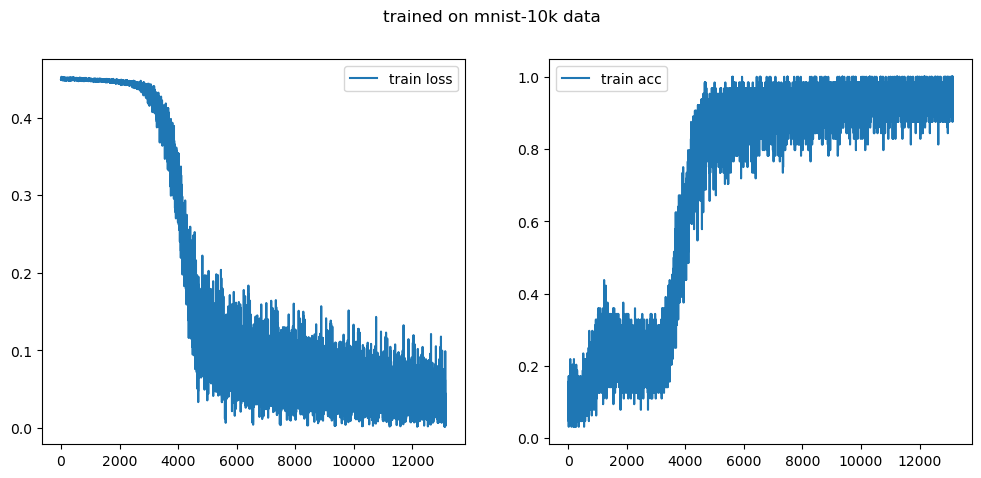

[(0.4494156241416931, 0.125),
 (0.4494408369064331, 0.078125),
 (0.4507347345352173, 0.109375),
 (0.4485909342765808, 0.15625),
 (0.45137810707092285, 0.0625),
 (0.4495450258255005, 0.09375),
 (0.4507558047771454, 0.0625),
 (0.44950467348098755, 0.125),
 (0.45028018951416016, 0.09375),
 (0.451774537563324, 0.046875),
 (0.4502187967300415, 0.09375),
 (0.45058107376098633, 0.078125),
 (0.4523484408855438, 0.046875),
 (0.4485652446746826, 0.171875),
 (0.4522440433502197, 0.03125),
 (0.4500412344932556, 0.109375),
 (0.44901928305625916, 0.0625),
 (0.45030808448791504, 0.140625),
 (0.45018771290779114, 0.0625),
 (0.44994643330574036, 0.109375),
 (0.4528266191482544, 0.109375),
 (0.45098578929901123, 0.046875),
 (0.45043474435806274, 0.125),
 (0.45122623443603516, 0.078125),
 (0.4507238566875458, 0.125),
 (0.44877734780311584, 0.109375),
 (0.4501327872276306, 0.109375),
 (0.4516669511795044, 0.0625),
 (0.4507484436035156, 0.09375),
 (0.4518892765045166, 0.09375),
 (0.4500792324542999, 0.125)

In [24]:
rez = []
opti.zero_grad()
for i in range(epochs):
    running_loss = []
    for j, batch in enumerate(train_dataloader):
        X,y = batch
        X,y = X.to(device), y.to(device)
        loss = loss_fn(network(X), y) / len(X)
        loss.backward()
        total_norm = 0
        for ii, p in enumerate(network.parameters()):
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        acc = acc_fn(network(X), y) / len(X)
        opti.step()
        opti.zero_grad()
        running_loss.append(loss.item())
        rez.append((loss.item(), acc.item()))
    print(f"epoch {i}, iters {len(train_dataloader)}, loss {np.mean(running_loss):.4f}")
    if acc > min_acc:
        break


rez_arr = np.array(rez)
smoothen_up = True
if smoothen_up:
    rez_arr = savgol_filter(rez_arr, window_length=93, polyorder=3, axis=0)

plt.figure(figsize=(12, 5))
plt.suptitle(f"trained on {train_dataset_name} data")
plt.subplot(1, 2, 1)
plt.plot(rez_arr[:, 0], label="train loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(rez_arr[:, 1], label="train acc")
plt.legend()
plt.show()

rez

In [25]:
train_rez = compute_losses(network, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True)
test_rez = []
for k, test_dataset in enumerate(test_datasets):
    test_rez.append(compute_losses(network, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True))
train_rez, test_rez

([tensor(0.0390, device='cuda:0'), tensor(0.9497, device='cuda:0')],
 [[tensor(0.0363, device='cuda:0'), tensor(0.9538, device='cuda:0')],
  [tensor(0.6545, device='cuda:0'), tensor(0.2471, device='cuda:0')],
  [tensor(0.8141, device='cuda:0'), tensor(0.0633, device='cuda:0')],
  [tensor(0.7656, device='cuda:0'), tensor(0.0807, device='cuda:0')]])

In [26]:
if train_dataset_name.startswith("mnist"):  
    torch.save(network.state_dict(), f"/home/mateusz.pyla/stan/atelier/sharpness/pruning/lenet_{train_dataset_name}.pt")
elif train_dataset_name.startswith("fashion"):
    torch.save(network.state_dict(), f"/home/mateusz.pyla/stan/atelier/sharpness/pruning/lenet_{train_dataset_name}.pt")
elif train_dataset_name.startswith("cifar"):
    torch.save(network.state_dict(), f"/home/mateusz.pyla/stan/atelier/sharpness/pruning/resnet9_{train_dataset_name}.pt")

## Mutliple

In [41]:
def init_training(dataset_name):
    if dataset_name.startswith("mnist") or dataset_name.startswith("fashion"):
        return init_training_mnist()
    else:
        return init_training_cifar()

def init_training_mnist():
    network = LeNet(input_shape=[28, 28, 1], output_shape=10, softmax=True, pooling="max").to(device)
    network.train()
    return network

def init_training_cifar():
    network = ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True).to(device)
    network.train()
    return network

In [51]:
def do_single_training(network, loss_fn, acc_fn, opti, epochs, train_dataset, batch_size, min_acc):
    rez = []
    network.train()
    opti.zero_grad()
    for i in range(epochs):
        for j, batch in enumerate(iterate_dataset(train_dataset, batch_size)):
            X, y = batch
            X, y = X.to(device), y.to(device)
            loss = loss_fn(network(X), y) / len(X)
            loss.backward()
            total_norm = 0
            for ii, p in enumerate(network.parameters()):
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            acc = acc_fn(network(X), y) / len(X)
            opti.step()
            opti.zero_grad()
            rez.append((loss.item(), acc.item()))
            if j % 100 == 0:
                print(f"epoch {i}, iteration {j}, loss {loss.item()}, acc {acc.item()}")
        if acc > min_acc:
            break
    print(rez[-1])
    return rez

In [55]:
def do_many_trainings(train_dataset_name, test_datasets_names, lrs, epochs, min_acc = 0.99):
    loss_fn, acc_fn = get_loss_and_acc(loss_name)

    results = {}

    for lr, epoch in zip(lrs, epochs):
        print(f"training with lr {lr} for {epoch} epochs")
        network = init_training(train_dataset_name)
        opti = optim.SGD(list(filter(lambda p: p.requires_grad, network.parameters())), lr)
        train_dataset, train_dataloader, test_datasets, test_dataloaders = prepare_data(train_dataset_name, test_datasets_names, loss_name, train_batch_size, test_batch_size)
        rez = do_single_training(network, loss_fn, acc_fn, opti, epoch, train_dataset, train_batch_size, min_acc)
        train_rez = compute_losses(network, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True).item()
        test_rez = []
        for k, test_dataset in enumerate(test_datasets):
            test_rez.append(compute_losses(network, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True).item())
        results[lr] = network, rez, train_rez, test_rez
    return results

In [53]:
loss_fn, acc_fn = get_loss_and_acc(loss_name)
train_dataset_name = "mnist-10k"
test_datasets_names = ["mnistt", "mnistct_brightness", "fashiont", "fashionct"]
train_dataset, train_dataloader, test_datasets, test_dataloaders = prepare_data(train_dataset_name, test_datasets_names, loss_name, train_batch_size, test_batch_size)
ex = test_datasets[0][0][0].unsqueeze(0).to(device)

/tmp/ipykernel_150772/3938385040.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_targets = make_labels(torch.tensor(new_targets), loss)
/tmp/ipykernel_150772/2892071345.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_targets = make_labels(torch.tensor(new_targets), loss)


In [54]:
lrs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
epochs = [int(1/lr) for lr in lrs]
results = do_many_trainings(train_dataset_name, test_datasets_names, lrs, epochs)

/tmp/ipykernel_150772/3938385040.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_targets = make_labels(torch.tensor(new_targets), loss)
/tmp/ipykernel_150772/2892071345.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_targets = make_labels(torch.tensor(new_targets), loss)


epoch 0, iteration 0, loss 0.45051369071006775, acc 0.09375
epoch 0, iteration 100, loss 0.4513830542564392, acc 0.078125
epoch 0, iteration 200, loss 0.44939783215522766, acc 0.09375
epoch 0, iteration 300, loss 0.45130062103271484, acc 0.0625
epoch 0, iteration 400, loss 0.4493633508682251, acc 0.09375
epoch 0, iteration 500, loss 0.4500468373298645, acc 0.09375
epoch 0, iteration 600, loss 0.4509316682815552, acc 0.125
epoch 0, iteration 700, loss 0.4496456980705261, acc 0.09375
epoch 0, iteration 800, loss 0.45053157210350037, acc 0.09375
epoch 0, iteration 900, loss 0.45161622762680054, acc 0.046875
epoch 1, iteration 0, loss 0.450425922870636, acc 0.09375
epoch 1, iteration 100, loss 0.4512885510921478, acc 0.078125
epoch 1, iteration 200, loss 0.4493478536605835, acc 0.09375
epoch 1, iteration 300, loss 0.4511810541152954, acc 0.0625
epoch 1, iteration 400, loss 0.44933897256851196, acc 0.09375
epoch 1, iteration 500, loss 0.4500024914741516, acc 0.09375
epoch 1, iteration 600, 

/tmp/ipykernel_150772/292970821.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/tmp/ipykernel_150772/292970821.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 0].scatter(lr, train_rez[1].item(), c=colors[i], label=f"{lr} train")
/tmp/ipykernel_150772/292970821.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or p

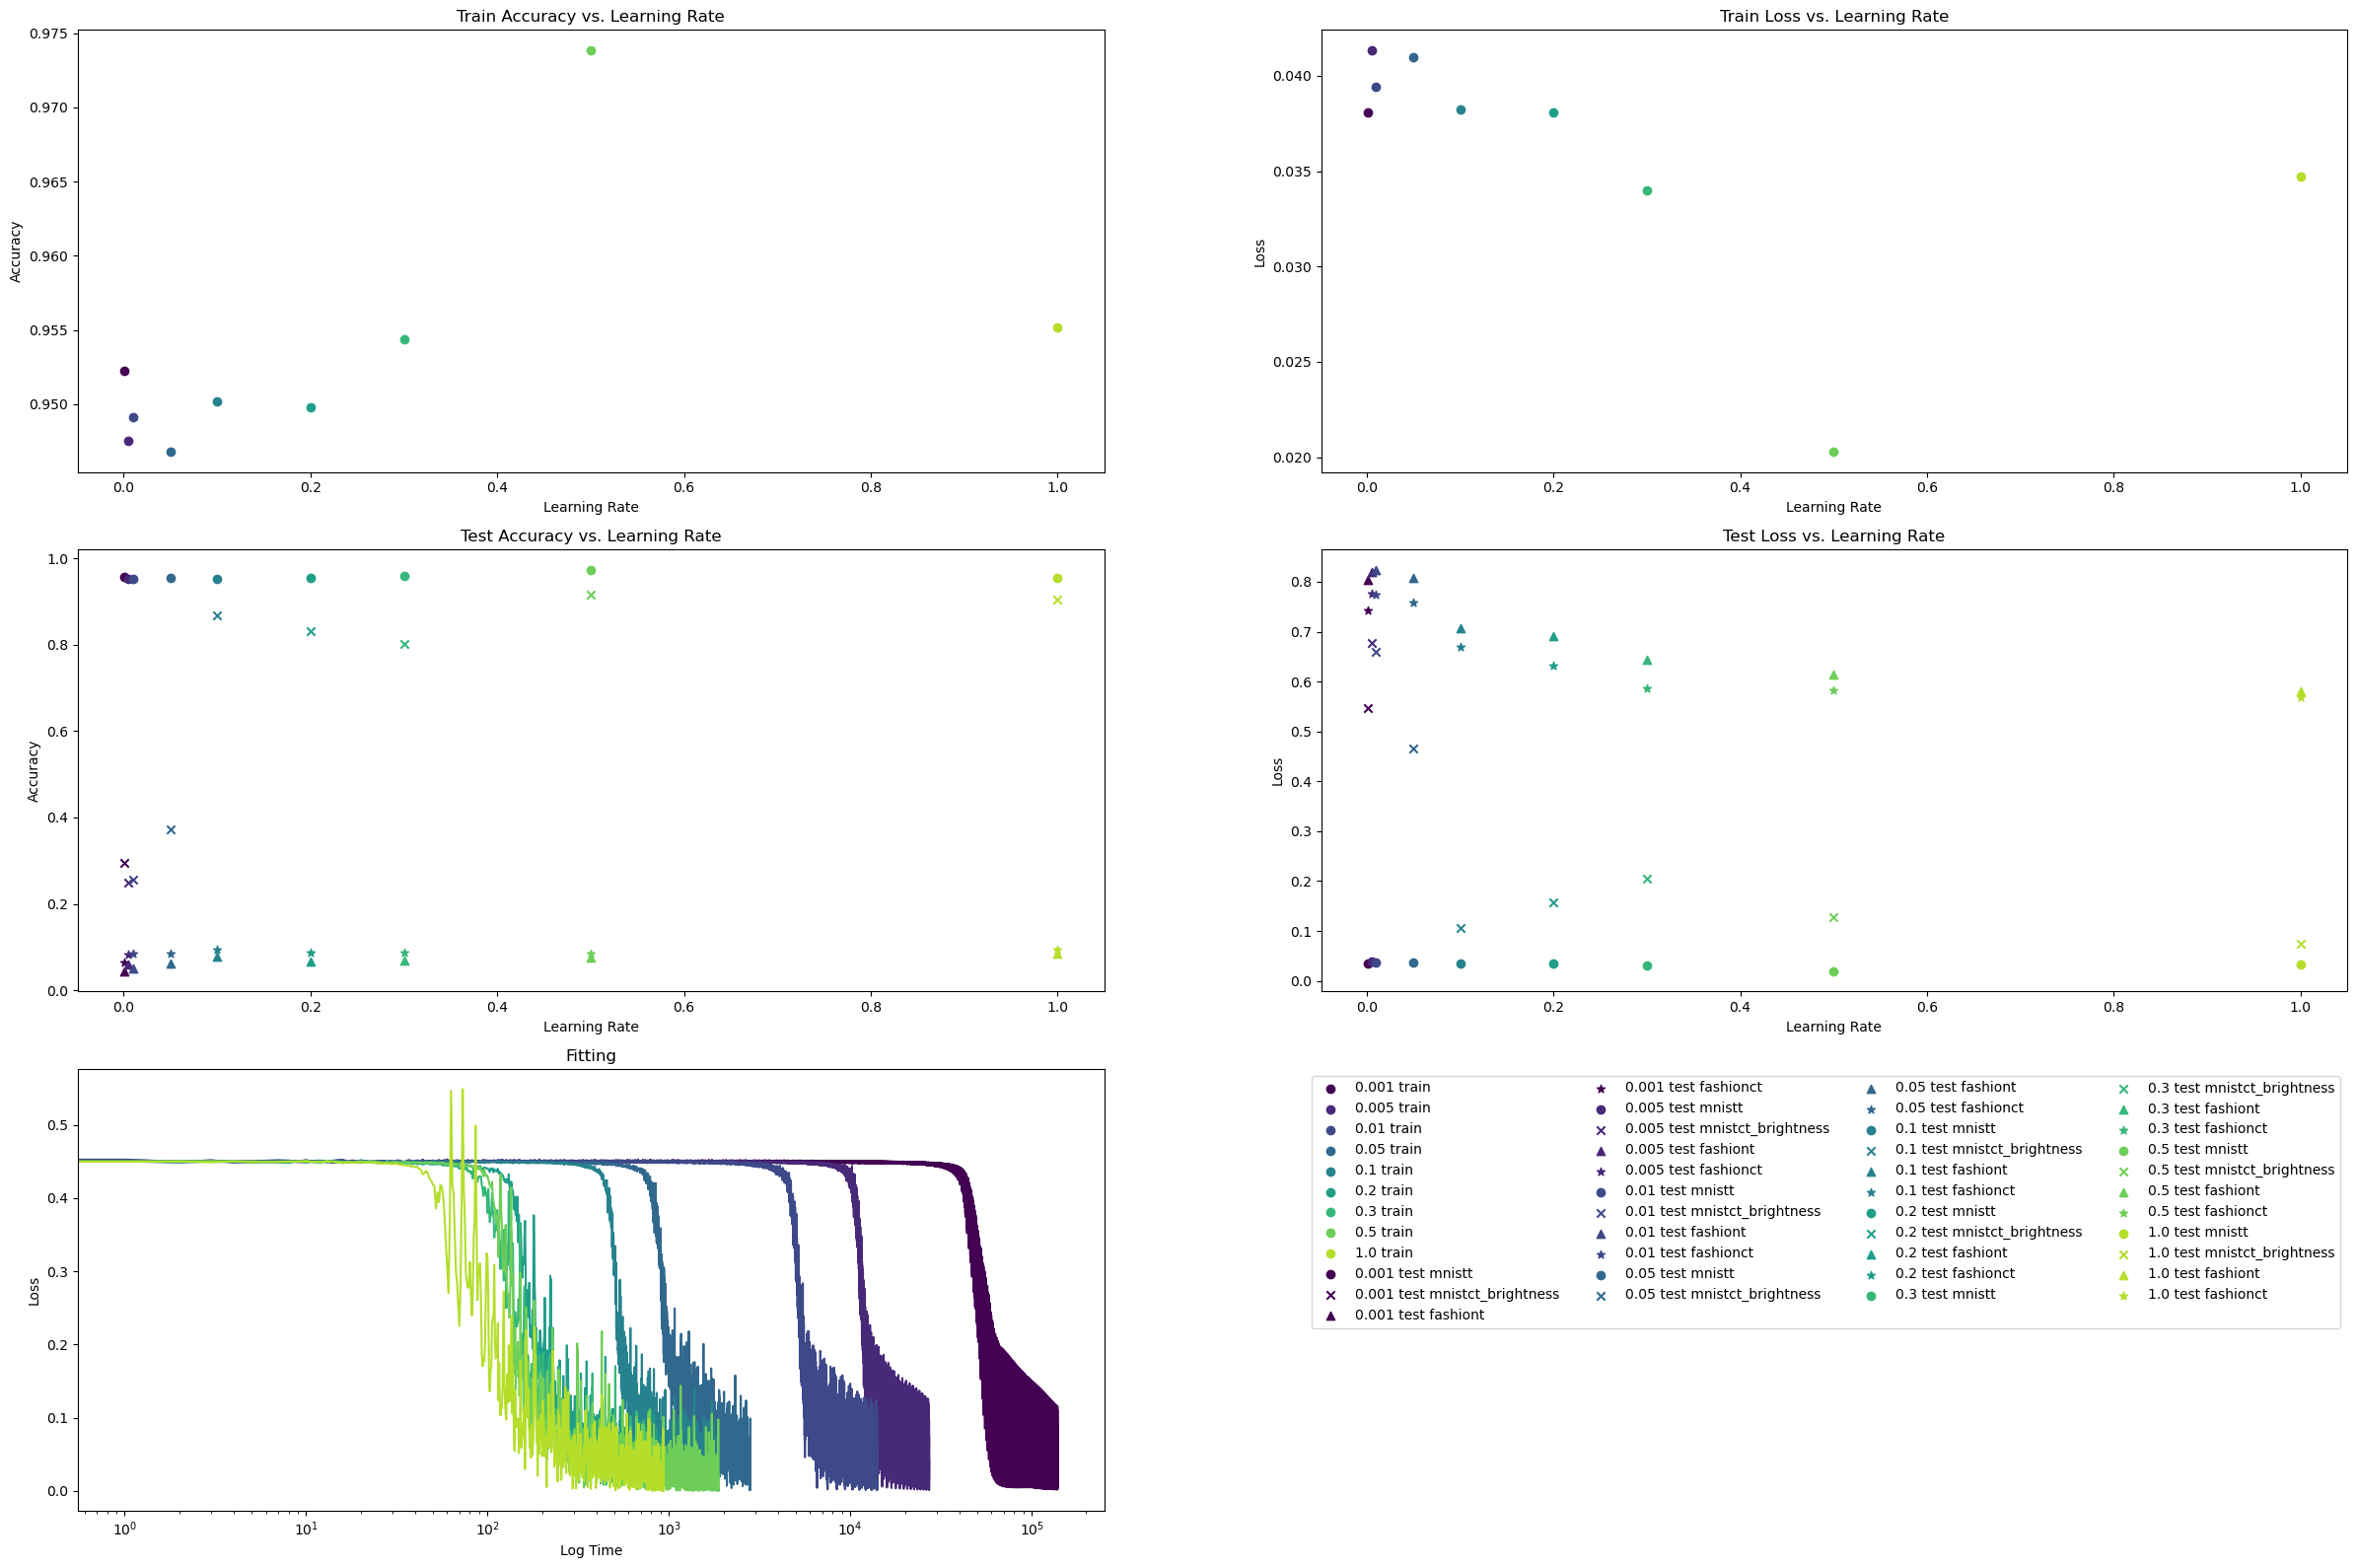

In [102]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))

cmap = cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

markers = ["o", "x", "^", "*", "s"]

axs[0, 0].set_title("Train Accuracy vs. Learning Rate")
axs[0, 0].set_xlabel("Learning Rate")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 1].set_title("Train Loss vs. Learning Rate")
axs[0, 1].set_xlabel("Learning Rate")
axs[0, 1].set_ylabel("Loss")
axs[1, 0].set_title("Test Accuracy vs. Learning Rate")
axs[1, 0].set_xlabel("Learning Rate")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 1].set_title("Test Loss vs. Learning Rate")
axs[1, 1].set_xlabel("Learning Rate")
axs[1, 1].set_ylabel("Loss")
axs[2, 0].set_title("Fitting")
axs[2, 0].set_xlabel("Log Time")
axs[2, 0].set_ylabel("Loss")

for i, lr in enumerate(results.keys()):
    network, rez, train_rez, test_rez = results[lr]
    axs[0, 0].scatter(lr, train_rez[1].item(), c=colors[i], label=f"{lr} train")
    axs[0, 1].scatter(lr, train_rez[0].item(), c=colors[i])
    for j in range(len(test_rez)):
        axs[1, 0].scatter(lr, test_rez[j][1].item(), c=colors[i], marker=markers[j], label=f"{lr} test {test_datasets_names[j]}")
        axs[1, 1].scatter(lr, test_rez[j][0].item(), c=colors[i], marker=markers[j])
    running_losses = np.array(rez)[:, 0]
    axs[2, 0].plot(running_losses, c=colors[i])
    axs[2, 0].set_xscale("log")

handles1, labels1 = axs[0, 0].get_legend_handles_labels()
handles2, labels2 = axs[1, 0].get_legend_handles_labels()
handles, labels = handles1 + handles2, labels1 + labels2

axs[2, 1].axis("off")
axs[2, 1].legend(handles, labels, fontsize=10, ncol=4) # loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.

plt.tight_layout()
plt.show()

## Pruning

In [34]:
def count_zero_parameters(model, eps=0.0001):
    zero_count = 0
    for param in model.parameters():
        if param is not None:
            zero_count += torch.sum(abs(param) < eps).item()
    return zero_count

In [35]:
def is_one_of(value, types):
    """Checks if a value is one of the given types."""
    return any(isinstance(value, t) for t in types)

In [36]:
def finetune(model, loss_fn, train_dataset, batch_size, lr, epochs):
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    for e in range(epochs):
        running_loss = []
        for (X, y) in iterate_dataset(train_dataset, batch_size):
            opt.zero_grad()
            X.to(device)
            out = model(X)
            loss = loss_fn(out, y) / len(X)
            running_loss.append(loss.item())
            loss.backward()
            opt.step()

In [38]:
class MySlimmingImportance(tp.importance.Importance):
    def __call__(self, group, **kwargs):
        #note that we have multiple BNs in a group, 
        # we store layer-wise scores in a list and then reduce them to get the final results
        group_imp = [] # (num_bns, num_channels) 
        # 1. iterate the group to estimate importance
        for dep, idxs in group:
            layer = dep.target.module # get the target model
            prune_fn = dep.handler    # get the pruning function of target model, unused in this example
            if isinstance(layer, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)) and layer.affine:
                local_imp = torch.abs(layer.weight.data)
                group_imp.append(local_imp)
        if len(group_imp)==0: return None # return None if the group contains no BN layer
        # 2. reduce your group importance to a 1-D scroe vector. Here we use the average score across layers.
        group_imp = torch.stack(group_imp, dim=0).mean(dim=0) 
        return group_imp # (num_channels, )

# You can implement any importance functions, as long as it transforms a group to a 1-D score vector.
class RandomImportance(tp.importance.Importance):
    @torch.no_grad()
    def __call__(self, group, **kwargs):
        _, idxs = group[0]
        return torch.rand(len(idxs))

class MaxMagnitudePruner(tp.importance.Importance):
    @torch.no_grad()
    def __call__(self, module):
        mask = torch.zeros_like(module.weight.data)
        abs_weights = torch.abs(module.weight.data)
        _, indices = torch.topk(abs_weights.flatten(), self.num_params_to_prune, largest=True, sorted=False)
        mask.view(-1)[indices] = 1
        return mask

In [42]:
pruned, pruned_training_rez, pruned_test_rez, pruned_stats = check_pruning(network, pruning_method=MaxMagnitudePruner, lst_types=[], iterative_steps=1, percent=0.5)

TypeError: MaxMagnitudePruner() takes no arguments

In [26]:
# lst_pruning_methods = [torch_pruning.pruner.MagnitudePruner]
# pruning_method = torch_pruning.pruner.ccc
# lst_types = []
# iterative_steps = 15
# pruned = prune_model(network, pruning_method, lst_types, iterative_steps, percent=0.5)
# pruned_training_rez = compute_losses(pruned, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True)
# pruned_test_rez = []
# for k, test_dataset in enumerate(test_datasets):
#     pruned_test_rez.append(compute_losses(pruned, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True))
# pruned_training_rez, pruned_test_rez

In [39]:
def prune_model(model, pruning_method, lst_types, iterative_steps, percent):
    model = copy.deepcopy(model)
    base_macs, base_nparams = tp.utils.count_ops_and_params(model, ex)
    ignored_layers = ["classifier"]
    for i, types in enumerate(lst_types):
        for m in model.named_parameters():
            if not is_one_of(m, types):
                ignored_layers.append(m)

    imp = tp.importance.MagnitudeImportance(p=2, group_reduction='mean')
    this_pruning_method = pruning_method(model, ex, importance=imp, iterative_steps=iterative_steps, 
                                        pruning_ratio=percent*0.01, global_pruning=False,
                                        ignored_layers=ignored_layers)

    for k in range(iterative_steps):
        for group in this_pruning_method.step(interactive=True):
            for dep, idxs in group:
                target_layer = dep.target.module
                pruning_fn = dep.handler
                if pruning_fn in [tp.prune_conv_in_channels, tp.prune_linear_in_channels]:
                    target_layer.weight.data[:, idxs] *= 0
                elif pruning_fn in [tp.prune_conv_out_channels, tp.prune_linear_out_channels]:
                    target_layer.weight.data[idxs] *= 0
                    if target_layer.bias is not None:
                        target_layer.bias.data[idxs] *= 0
                elif pruning_fn in [tp.prune_batchnorm_out_channels]:
                    target_layer.weight.data[idxs] *= 0
                    target_layer.bias.data[idxs] *= 0

    pruned_macs, pruned_nparams = tp.utils.count_ops_and_params(model, ex)
    nparams = count_zero_parameters(model)
    return model, nparams

In [40]:
def check_pruning(model, pruning_method, lst_types, iterative_steps, percent):
    pruned, zero_params = prune_model(model, pruning_method, lst_types, iterative_steps, percent)
    pruned_training_rez = compute_losses(pruned, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True)
    pruned_test_rez = []
    for k, test_dataset in enumerate(test_datasets):
        pruned_test_rez.append(compute_losses(pruned, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True))
    return pruned, pruned_training_rez, pruned_test_rez, zero_params/(sum(p.numel() for p in model.parameters() if p.requires_grad))

### Check pruning for many

In [96]:

results_pruning = {}
pruning_method = tp.pruner.MagnitudePruner
lst_types = []
iterative_steps = 5
ps = [0.01, 0.1, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 66.0, 75.0, 90.0, 95.0, 99.0]

for lr in lrs:
    network = results[lr][0]
    results_pruning[lr] = {}
    for p in ps:
        pruned, pruned_training_rez, pruned_test_rez, pruned_ratio = check_pruning(network, pruning_method, lst_types, iterative_steps, p)
        results_pruning[lr][p] = pruned, pruned_training_rez, pruned_test_rez, pruned_ratio

/tmp/ipykernel_150772/2204447150.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/tmp/ipykernel_150772/2204447150.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(p, pruned_training_rez[1].item(), marker="o", c=colors[i], alpha=0.5, label=f"lr {lr} p {p} {train_dataset_name}")
/tmp/ipykernel_150772/2204447150.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 

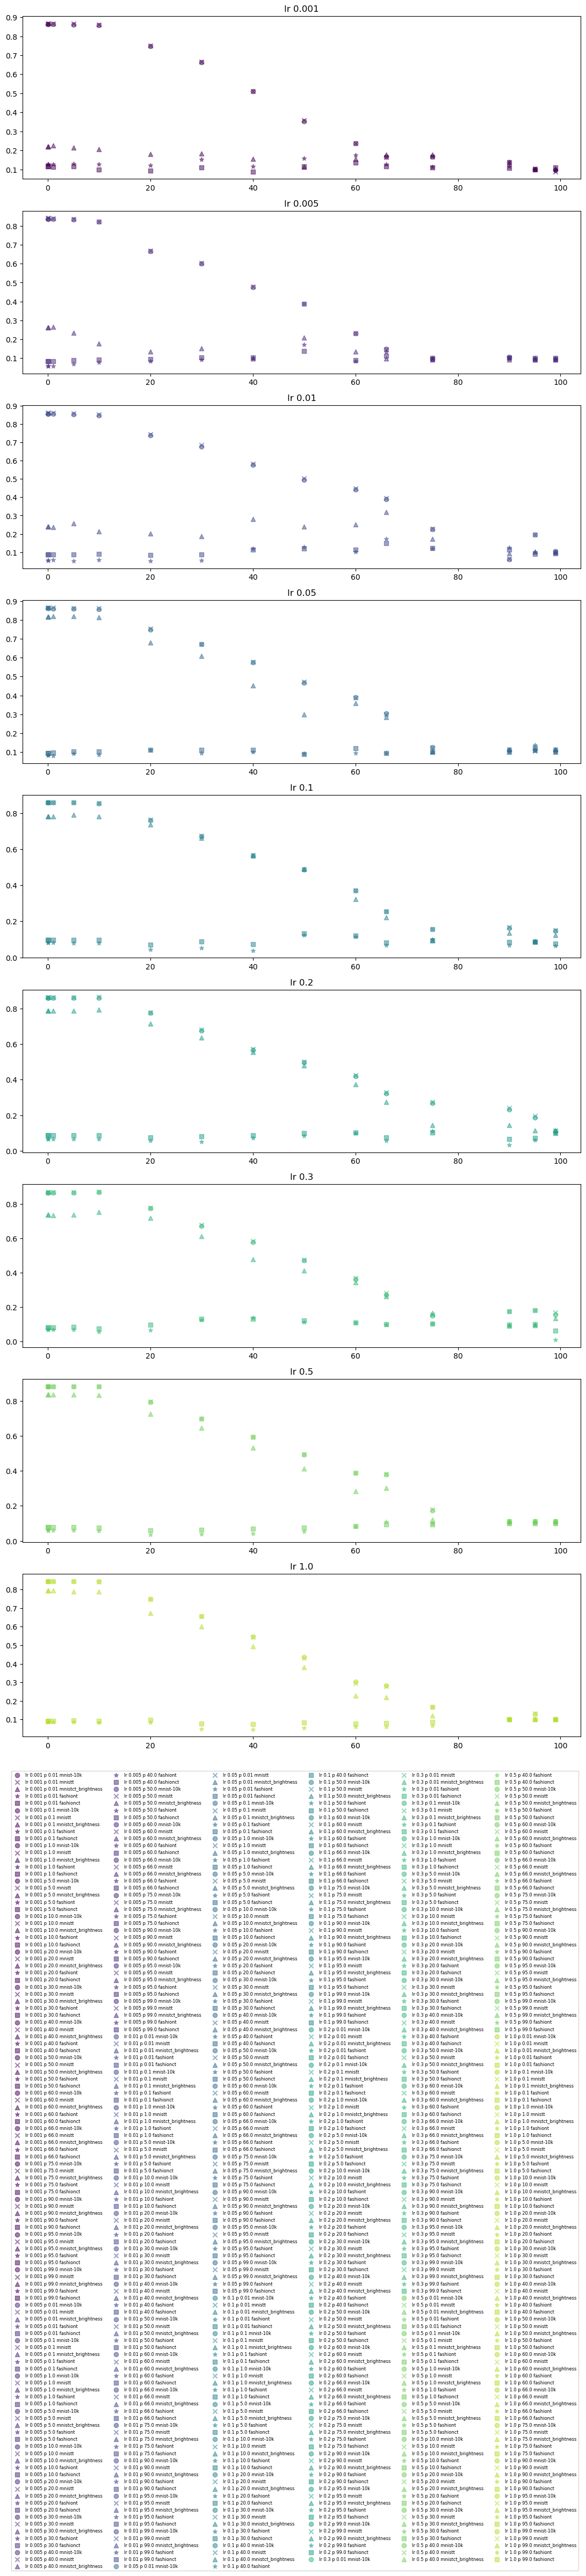

In [98]:
fig, axs = plt.subplots(len(lrs)+1, figsize=(12, 48))

cmap = cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
markers = ["o", "x", "^", "*", "s"]

handles, labels = [], []

for i, lr in enumerate(lrs):
    axs[i].set_title(f"lr {lr}")
    for p in ps:
        pruned, pruned_training_rez, pruned_test_rez, pruned_ratio = results_pruning[lr][p]
        axs[i].scatter(p, pruned_training_rez[1].item(), marker="o", c=colors[i], alpha=0.5, label=f"lr {lr} p {p} {train_dataset_name}")
        for j in range(len(pruned_test_rez)):
            axs[i].scatter(p, pruned_test_rez[j][1].item(), marker=markers[j+1], c=colors[i], alpha=0.5, label=f"lr {lr} p {p} {test_datasets_names[j]}")

    handles1, labels1 = axs[i].get_legend_handles_labels()
    handles = handles + handles1
    labels = labels + labels1

axs[len(lrs)].axis("off")
axs[len(lrs)].legend(handles, labels, fontsize=6, ncol=6)
plt.tight_layout()
plt.savefig("pruning_night.png")
plt.show()

## Aggregate

In [79]:
exp_models = {"vanilla": network}
exp_train_acc = {"vanilla": train_rez[1]}
exp_train_loss = {"vanilla": train_rez[0]}
exp_test_accs = {"vanilla": [x[1] for x in test_rez]}
exp_test_losss = {"vanilla": [x[0] for x in test_rez]}
exp_ratio = {"vanilla": 0.0}
ps = [0.01, 0.1, 1.0, 5.0, 10.0, 20.0, 30.0, 50.0, 75.0, 90.0, 99.0]
for p in ps:
    pruned, pruned_training_rez, pruned_test_rez, pruned_ratio = check_pruning(network, pruning_method, lst_types, iterative_steps, p)
    exp_train_acc[p] = pruned_training_rez[1]
    exp_train_loss[p] = pruned_training_rez[0]
    exp_test_accs[p] = [x[1] for x in pruned_test_rez]
    exp_test_losss[p] = [x[0] for x in pruned_test_rez]
    exp_ratio[p] = pruned_ratio
    exp_models[p] = pruned
n_colors = len(ps)

In [29]:
def plot_exp(ps, exp_train_acc, exp_train_loss, exp_test_accs, exp_test_losss, exp_ratio):
    fig, axs = plt.subplots(3, 2, figsize=(30, 20))
    plt.tight_layout()
    cmap = plt.cm.get_cmap('viridis')
    markers = ["o", "x", "^", "*", "s"]
    plt.suptitle(f"trained on {train_dataset_name} {[(test_dataset_name,markers[k]) for k,test_dataset_name in enumerate(test_datasets_names)]}", fontsize=20)
    

    # IN ACC
    for i, p in enumerate(ps):
        v = exp_train_acc[p].item()
        axs[0, 0].scatter([p], [v], color=cmap(i/len(ps)))
        axs[0, 0].set_ylim(0, 1)
    #axs[0].text(0.0, -0.01, f"trained on {train_dataset_name}" , fontsize=15)
    # IN LOSS
    for i, p in enumerate(ps):
        v = exp_train_loss[p].item()
        axs[0, 1].scatter([p], [v], color=cmap(i/len(ps)))
        axs[0, 1].set_ylim(0.25, 0.75)
    # OUT ACC
    for i, p in enumerate(ps):
        for j, v in enumerate(exp_test_accs[p]):
            v = v.item()
            axs[1, 0].scatter([p], [v], color=cmap(i/len(ps)), marker=markers[j])
        axs[1, 0].set_ylim(0, 1)
    #axs[2].text(0.0, -0.01, f"{[(test_dataset_name,markers[k]) for k,test_dataset_name in enumerate(test_datasets_names)]}", fontsize=15)
    # OUT LOSS
    for i, p in enumerate(ps):
        for j, v in enumerate(exp_test_losss[p]):
            v = v.item()
            axs[1, 1].scatter([p], [v], color=cmap(i/len(ps)), marker=markers[j])
            axs[1, 1].set_ylim(0.25, 0.75)
    # RATIO
    for i, p in enumerate(ps):
        v = exp_ratio[p]
        axs[2, 0].scatter([p], [v], color=cmap(i/len(ps)), label=str(p))

    axs[2, 0].legend()

    axs[2, 1].axis('off')
    
    # LEGEND
    #axs[5].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #axs[5].axis('off')  # Turn off the axis for the legend subplot

    axs[0, 0].set_title('In accuracy')
    axs[0, 1].set_title('In loss')
    axs[1, 0].set_title('Out accuracy')
    axs[1, 1].set_title('Out loss')
    axs[2, 0].set_title('Ratio')
    axs[0, 0].set_xlabel('percent')
    axs[0, 1].set_xlabel('percent')
    axs[1, 0].set_xlabel('percent')
    axs[1, 1].set_xlabel('percent')
    axs[2, 0].set_xlabel('percent')

    # plt.subplots_adjust(wspace=1.0)

    return fig

/tmp/ipykernel_59396/542315559.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


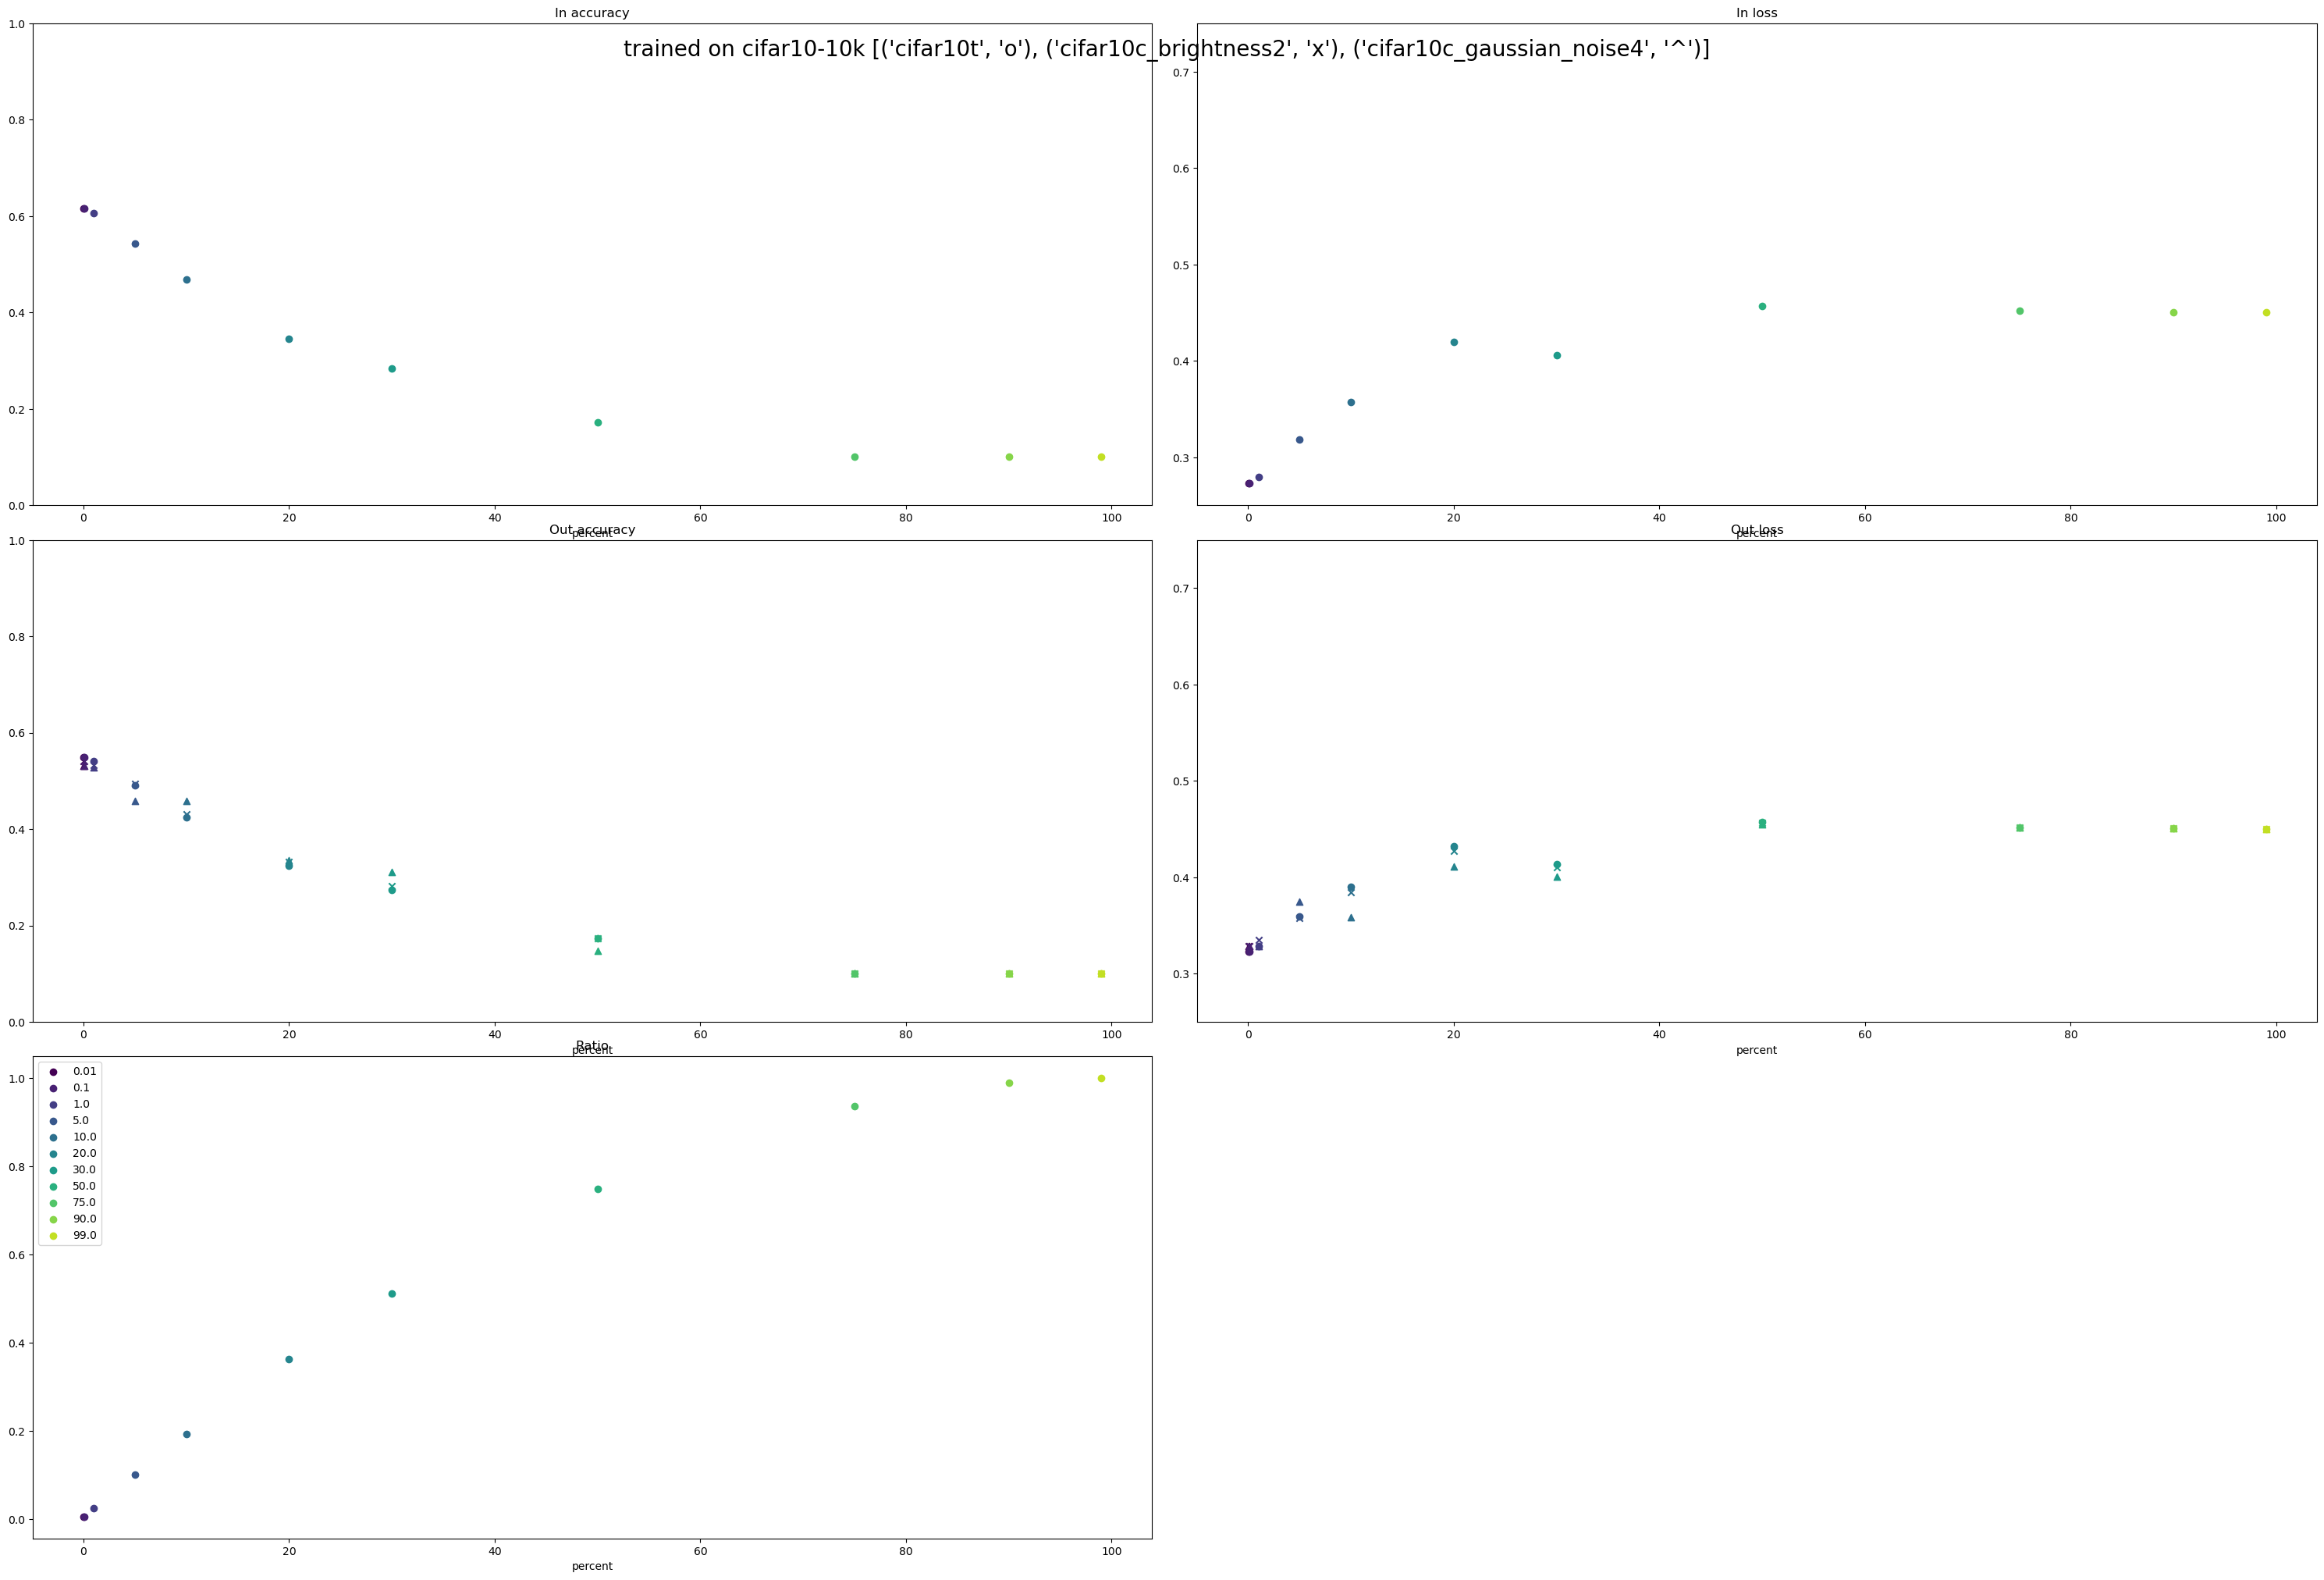

In [80]:
f = plot_exp(ps, exp_train_acc, exp_train_loss, exp_test_accs, exp_test_losss, exp_ratio)

/tmp/ipykernel_59396/542315559.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


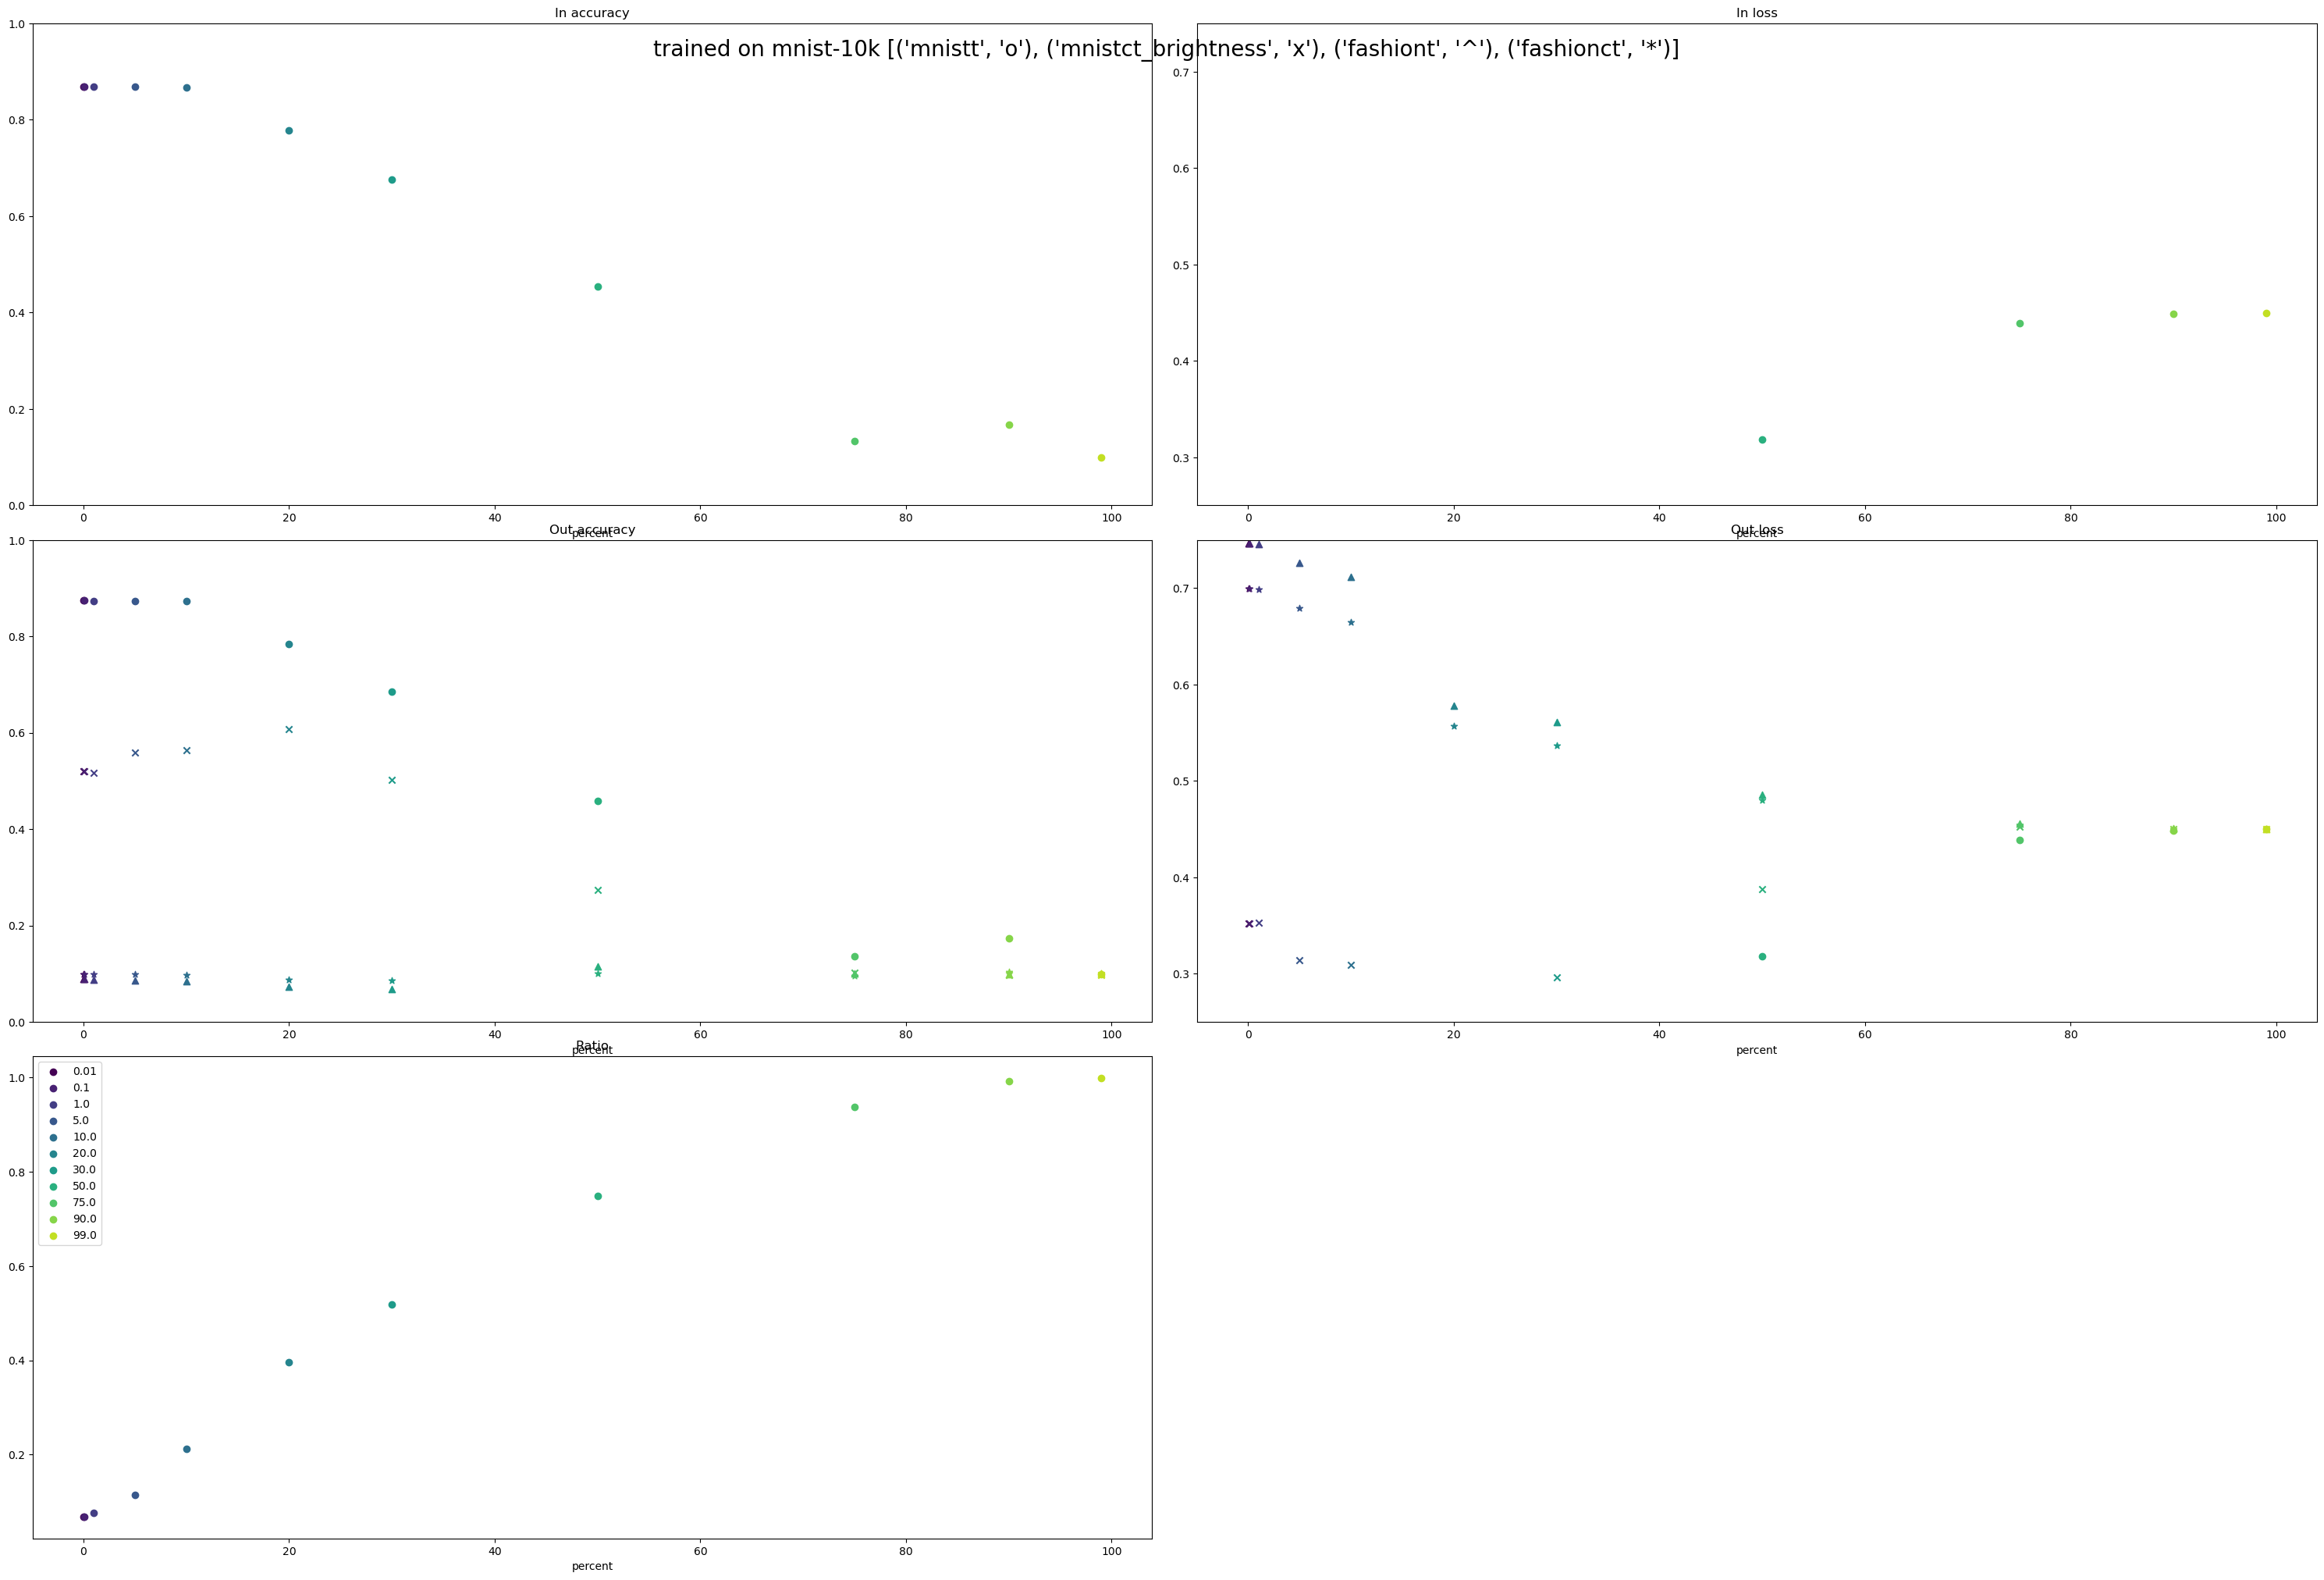

In [30]:
f = plot_exp(ps, exp_train_acc, exp_train_loss, exp_test_accs, exp_test_losss, exp_ratio)